# This vgg uni model is same as the fusio vgg16

In [1]:
import os

DATASET_BASE_PATH = '/kaggle/input/symile-mimic-1-0-0/symile-mimic-1.0.0/CSV'
BASE_IMAGE_PATH = '/kaggle/input/symile-mimic-1-0-0/symile-mimic-1.0.0/Images'

print("Checking paths...")
print(f"Base CSV path exists: {os.path.exists(DATASET_BASE_PATH)}")
if os.path.exists(DATASET_BASE_PATH):
    print("\nContents of CSV directory:")
    for item in os.listdir(DATASET_BASE_PATH):
        print(f"- {item}")
        if os.path.isdir(os.path.join(DATASET_BASE_PATH, item)):
            subdir = os.path.join(DATASET_BASE_PATH, item)
            print(f"  Contents of {item}:")
            for subitem in os.listdir(subdir):
                print(f"  - {subitem}")

print("\nChecking specific Atelectasis paths:")
atelectasis_dir = os.path.join(DATASET_BASE_PATH, 'Atelectasis')
print(f"Atelectasis directory exists: {os.path.exists(atelectasis_dir)}")
if os.path.exists(atelectasis_dir):
    print("\nContents of Atelectasis directory:")
    for file in os.listdir(atelectasis_dir):
        print(f"- {file}")

# Let's also check the image directory
print("\nChecking image paths...")
print(f"Base Image path exists: {os.path.exists(BASE_IMAGE_PATH)}")
if os.path.exists(BASE_IMAGE_PATH):
    print("\nContents of Images directory:")
    for item in os.listdir(BASE_IMAGE_PATH):
        print(f"- {item}")

Checking paths...
Base CSV path exists: True

Contents of CSV directory:
- Lung Opacity
  Contents of Lung Opacity:
  - Lung Opacity_test.csv
  - Lung Opacity_train.csv
  - Lung Opacity_val.csv
- Cardiomegaly
  Contents of Cardiomegaly:
  - Cardiomegaly_val.csv
  - Cardiomegaly_train.csv
  - Cardiomegaly_test.csv
- Edema
  Contents of Edema:
  - Edema_test.csv
  - Edema_val.csv
  - Edema_train.csv
- Atelectasis
  Contents of Atelectasis:
  - Atelectasis_test.csv
  - Atelectasis_val.csv
  - Atelectasis_train.csv
- Pleural Effusion
  Contents of Pleural Effusion:
  - Pleural Effusion_train.csv
  - Pleural Effusion_val.csv
  - Pleural Effusion_test.csv

Checking specific Atelectasis paths:
Atelectasis directory exists: True

Contents of Atelectasis directory:
- Atelectasis_test.csv
- Atelectasis_val.csv
- Atelectasis_train.csv

Checking image paths...
Base Image path exists: True

Contents of Images directory:
- val_images
- train_images
- test_images


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from typing import Tuple, Optional

warnings.filterwarnings('ignore')


DATASET_BASE_PATH = '/kaggle/input/symile-mimic-1-0-0/symile-mimic-1.0.0/CSV'

ANALYSIS_CONDITIONS = [
    'Atelectasis',
    'Cardiomegaly',
    'Edema',
    'Lung Opacity',
    'Pleural Effusion'
]

def analyze_class_csv_stats(class_name: str, dataset_base_path: str = DATASET_BASE_PATH) -> Optional[pd.DataFrame]:
    """
    Loads and provides statistical analysis for the train, validation, and test
    CSV files belonging to a specific class. Returns the train_df for plotting.
    """
    print("=" * 70)
    print(f"STATISTICAL ANALYSIS FOR CLASS: {class_name.upper()}")
    print("=" * 70)

    condition_path = os.path.join(dataset_base_path, class_name)
    train_df = None # Initialize to capture the training dataframe

    for split_type in ['train', 'val', 'test']:
        csv_filename = f'{class_name}_{split_type}.csv'
        csv_path = os.path.join(condition_path, csv_filename)

        df = None
        if os.path.exists(csv_path):
            try:
                df = pd.read_csv(csv_path)
                if split_type == 'train':
                    train_df = df
            except Exception as e:
                print(f"Error reading {csv_path}: {e}")

        if df is not None:
            print(f"\n--- {split_type.upper()} SET ({csv_filename}) ---")
            print(f"Total entries (Row Count): {len(df):,}")

            present_conditions = [c for c in ANALYSIS_CONDITIONS if c in df.columns]

            if present_conditions:
                print("\nCondition label distribution (per column):")

                for condition in present_conditions:
                    # Count of positive (1), negative (0),
                    count_positive = int((df[condition] == 1).sum())
                    count_negative = int((df[condition] == 0).sum())


                    total_labeled = count_positive + count_negative

                    percentage_positive = (count_positive / len(df)) * 100 if len(df) > 0 else 0.0

                    print(f"  • {condition:15}:")
                    print(f"    - Positive (1) : {count_positive:7,} ({percentage_positive:5.1f}%)")
                    print(f"    - Negative (0) : {count_negative:7,}")

                    print(f"    - Total Labeled: {total_labeled:7,}")
            else:
                print("No standard condition columns found for distribution analysis.")
        else:
            print(f"\n--- {split_type.upper()} SET ({csv_filename}) ---")
            print(f"Warning: CSV file not found at {csv_path}")

    return train_df

# -----------------------------------------------------------------------------

def visualize_training_label_distribution(class_name: str, train_df: pd.DataFrame):
    if train_df is None:
        print("\nCannot generate training label distribution: Training dataframe is missing.")
        return

    print("\n" + "~" * 70)
    print(f"PLOTTING TRAINING SET LABEL DISTRIBUTION FOR: {class_name.upper()}")
    print("~" * 70)

    df_to_analyze = train_df
    condition_cols = [c for c in ANALYSIS_CONDITIONS if c in df_to_analyze.columns]

    if not condition_cols:
        print("No columns found for plotting.")
        return


    label_counts = df_to_analyze[condition_cols].apply(pd.Series.value_counts).sum(axis=1)


    labels_to_plot = pd.Series(0, index=[ 0.0, 1.0])
    for label in label_counts.index:
        if label in labels_to_plot.index and not np.isnan(label):
            labels_to_plot[label] = label_counts[label]

    labels_to_plot = labels_to_plot.astype(int).sort_index()

    print(f"\nTraining Set total label counts: \n{labels_to_plot.to_string()}")

    # --- Plotting ---
    save_path = f'{class_name.lower()}_label_distribution.png'
    plt.figure(figsize=(8, 6))
    colors = { 0.0: '#FF6B6B', 1.0: '#4ECDC4'}
    x_labels = {

        0.0: r'$0$ (Negative)',
        1.0: r'$1$ (Positive)'
    }

    plt.bar([x_labels[l] for l in labels_to_plot.index], labels_to_plot.values,
            color=[colors[l] for l in labels_to_plot.index])

    plt.title(f'Training Set Label Distribution for {class_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Label Value', fontsize=12)
    plt.ylabel('Total Count Across All Condition Columns', fontsize=12)
    plt.xticks(rotation=15, ha='right')

    for i, v in enumerate(labels_to_plot.values):
        plt.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show() # Display the plot
    print(f"Plot saved as '{save_path}'")

print("Visulaizing function Defined")

Visulaizing function Defined


In [3]:
import os
import pandas as pd
from typing import Dict, List, Any

BASE_CSV_PATH = '/kaggle/input/symile-mimic-1-0-0/symile-mimic-1.0.0/CSV'
BASE_IMAGE_PATH = '/kaggle/input/symile-mimic-1-0-0/symile-mimic-1.0.0/Images'

SPLIT_IMAGE_FOLDERS = {
    'train': 'train_images',
    'val': 'val_images',
    'test': 'test_images'
}

# DATASET LOADER FUNCTION ---

def load_dataset(class_name: str) -> Dict[str, Dict[str, Any]]:

    if not os.path.exists(BASE_CSV_PATH):
        print(f"Error: Base CSV path not found: {BASE_CSV_PATH}")
        return {}

    result_data = {}
    condition_csv_path = os.path.join(BASE_CSV_PATH, class_name)

    print(f"\n--- Starting Data Load for Class: {class_name} ---")

    for split_type, img_folder in SPLIT_IMAGE_FOLDERS.items():
        csv_filename = f'{class_name}_{split_type}.csv'
        csv_path = os.path.join(condition_csv_path, csv_filename)

        df = None
        verified_paths = []

        if os.path.exists(csv_path):
            try:
                df = pd.read_csv(csv_path)

                base_img_folder = os.path.join(BASE_IMAGE_PATH, img_folder)

                if os.path.exists(base_img_folder):
                    # Iterate through CSV entries to verify image existence
                    for index, row in df.iterrows():
                        # Assumes 'cxr_path' column holds the image path/filename
                        raw_path = str(row['cxr_path']).replace('\\', '/')
                        filename = os.path.basename(raw_path)
                        full_img_path = os.path.join(base_img_folder, filename)

                        if os.path.exists(full_img_path):
                            verified_paths.append(full_img_path)

                print(f"  Loaded {split_type} CSV: {len(df):,} entries. Verified images: {len(verified_paths):,}.")

            except Exception as e:
                print(f"  Error processing {csv_path}: {e}")

        else:
            print(f"  Warning: CSV not found for {split_type} at {csv_path}")

        # Store the results, even if data loading failed
        result_data[split_type] = {
            'df': df,
            'image_paths': verified_paths
        }
    print("Sucesfully Loaded Dataset")

    return result_data

print("DataSet Laoder function Defined")



DataSet Laoder function Defined


# Atelectasis

STATISTICAL ANALYSIS FOR CLASS: ATELECTASIS

--- TRAIN SET (Atelectasis_train.csv) ---
Total entries (Row Count): 4,331

Condition label distribution (per column):
  • Atelectasis    :
    - Positive (1) :   2,867 ( 66.2%)
    - Negative (0) :   1,464
    - Total Labeled:   4,331

--- VAL SET (Atelectasis_val.csv) ---
Total entries (Row Count): 342

Condition label distribution (per column):
  • Atelectasis    :
    - Positive (1) :     225 ( 65.8%)
    - Negative (0) :     117
    - Total Labeled:     342

--- TEST SET (Atelectasis_test.csv) ---
Total entries (Row Count): 2,143

Condition label distribution (per column):
  • Atelectasis    :
    - Positive (1) :   1,409 ( 65.7%)
    - Negative (0) :     734
    - Total Labeled:   2,143

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PLOTTING TRAINING SET LABEL DISTRIBUTION FOR: ATELECTASIS
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Training Set total label counts: 
0.0    1464
1.0  

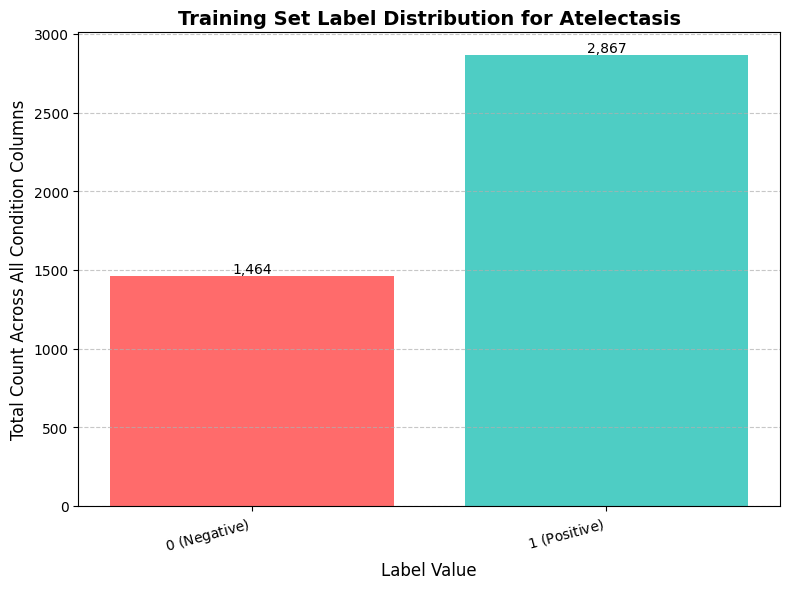

Plot saved as 'atelectasis_label_distribution.png'

--- Starting Data Load for Class: Atelectasis ---
  Loaded train CSV: 4,331 entries. Verified images: 4,331.
  Loaded val CSV: 342 entries. Verified images: 342.
  Loaded test CSV: 2,143 entries. Verified images: 2,143.
Sucesfully Loaded Dataset


In [5]:
target_class="Atelectasis"
# 1. Analyze the CSVs and retrieve the training dataframe
train_df_result = analyze_class_csv_stats(class_name=target_class)
# 2. Plot the label distribution for the retrieved training dataframe
visualize_training_label_distribution(class_name=target_class, train_df=train_df_result)
loaded_data = load_dataset(class_name="Atelectasis")

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from PIL import Image

# Custom Dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, image_paths, transform=None):
        self.dataframe = dataframe
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Get the label from the dataframe
        df_idx = self.dataframe.index[self.dataframe['cxr_path'].str.contains(os.path.basename(img_path))][0]
        label = torch.tensor(self.dataframe.iloc[df_idx]['Atelectasis'], dtype=torch.float32)

        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print ("Atelectasis CXR dataset loaded" )

Atelectasis CXR dataset loaded



--- Starting VGG Model Initialization (VGG16 on Atelectasis dataset) ---


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 202MB/s] 


Using 2 GPUs! Training in parallel.

--- Starting VGG16 Model Training ---


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1/20 | Time: 54.94s
Training:    Loss: 0.0959, Acc: 0.5525, F1: 0.5401, AUC: 0.5586
Validation: Loss: 0.0766, Acc: 0.6959, F1: 0.7536, AUC: 0.7464
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7464


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2/20 | Time: 44.26s
Training:    Loss: 0.0869, Acc: 0.5978, F1: 0.5893, AUC: 0.6290
Validation: Loss: 0.0723, Acc: 0.7456, F1: 0.8045, AUC: 0.7663
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7663


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 3/20 | Time: 42.97s
Training:    Loss: 0.0840, Acc: 0.6073, F1: 0.6128, AUC: 0.6493
Validation: Loss: 0.0732, Acc: 0.7310, F1: 0.7840, AUC: 0.7777
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7777


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 4/20 | Time: 43.00s
Training:    Loss: 0.0819, Acc: 0.6303, F1: 0.6300, AUC: 0.6739
Validation: Loss: 0.0716, Acc: 0.7427, F1: 0.7982, AUC: 0.7903
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7903

Epoch 5: Unfreezing last two convolutional blocks (Block 4 and 5).



Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 5/20 | Time: 48.92s
Training:    Loss: 0.0784, Acc: 0.6527, F1: 0.6527, AUC: 0.7092
Validation: Loss: 0.0647, Acc: 0.8012, F1: 0.8553, AUC: 0.8187
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8187


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6/20 | Time: 48.33s
Training:    Loss: 0.0764, Acc: 0.6712, F1: 0.6843, AUC: 0.7333
Validation: Loss: 0.0673, Acc: 0.7661, F1: 0.8122, AUC: 0.8304
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8304


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 7/20 | Time: 47.64s
Training:    Loss: 0.0742, Acc: 0.6899, F1: 0.7018, AUC: 0.7532
Validation: Loss: 0.0767, Acc: 0.6784, F1: 0.7074, AUC: 0.8395
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8395


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 8/20 | Time: 48.14s
Training:    Loss: 0.0729, Acc: 0.7010, F1: 0.7091, AUC: 0.7639
Validation: Loss: 0.0621, Acc: 0.7895, F1: 0.8400, AUC: 0.8429
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8429


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 9/20 | Time: 48.94s
Training:    Loss: 0.0714, Acc: 0.7095, F1: 0.7181, AUC: 0.7760
Validation: Loss: 0.0638, Acc: 0.7953, F1: 0.8423, AUC: 0.8443
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8443


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 10/20 | Time: 48.25s
Training:    Loss: 0.0713, Acc: 0.7125, F1: 0.7305, AUC: 0.7779
Validation: Loss: 0.0617, Acc: 0.8070, F1: 0.8540, AUC: 0.8567
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8567


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 11/20 | Time: 48.22s
Training:    Loss: 0.0716, Acc: 0.7061, F1: 0.7179, AUC: 0.7773
Validation: Loss: 0.0656, Acc: 0.7924, F1: 0.8329, AUC: 0.8555


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 12/20 | Time: 49.51s
Training:    Loss: 0.0703, Acc: 0.7158, F1: 0.7284, AUC: 0.7900
Validation: Loss: 0.0595, Acc: 0.8216, F1: 0.8677, AUC: 0.8471


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 13/20 | Time: 49.89s
Training:    Loss: 0.0686, Acc: 0.7324, F1: 0.7433, AUC: 0.8014
Validation: Loss: 0.0590, Acc: 0.8246, F1: 0.8718, AUC: 0.8476


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 14/20 | Time: 49.91s
Training:    Loss: 0.0708, Acc: 0.7188, F1: 0.7366, AUC: 0.7808
Validation: Loss: 0.0608, Acc: 0.8070, F1: 0.8533, AUC: 0.8487


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 15/20 | Time: 49.54s
Training:    Loss: 0.0673, Acc: 0.7372, F1: 0.7511, AUC: 0.8100
Validation: Loss: 0.0632, Acc: 0.7807, F1: 0.8276, AUC: 0.8475

Early stopping: Validation AUC did not improve for 5 epochs.

--- Storing Training History and Plots ---


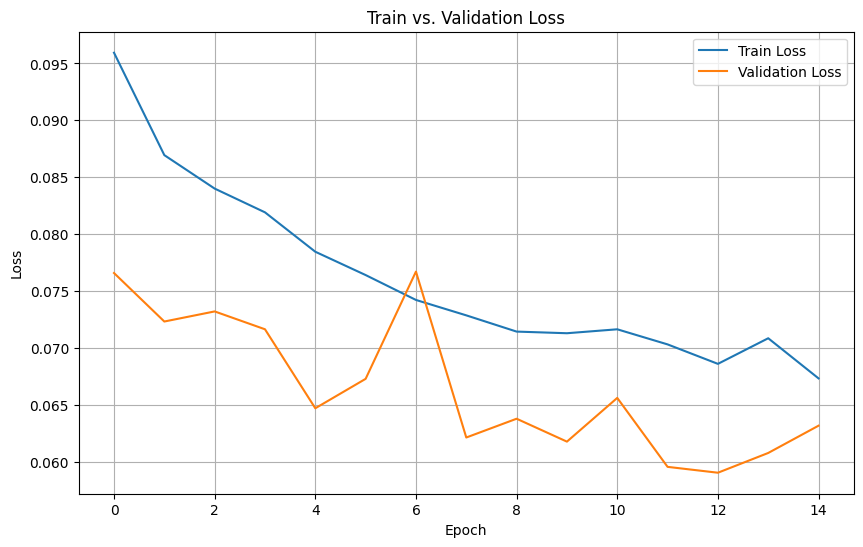


Model training history saved.

--- Starting Final Evaluation on Test Dataset ---


Testing:   0%|          | 0/34 [00:00<?, ?it/s]


Optimal Threshold found: 0.3774

Final Test Set Evaluation Scores
                        Score  95% CI Lower  95% CI Upper
Metric                                                   
AUC                  0.747469      0.724993      0.769334
Accuracy (Optimal)   0.719085      0.700875      0.738217
F1-Score (Optimal)   0.813622      0.799124      0.827611
Precision (Optimal)  0.721582      0.701154      0.740546
Recall (Optimal)     0.932576      0.918994      0.945158
Accuracy (Default)   0.712086      0.694809      0.730775
F1-Score (Default)   0.779091      0.762944      0.795400
Precision (Default)  0.786127      0.766148      0.806078
Recall (Default)     0.772179      0.751235      0.793915

Evaluation scores saved to 'evaluation_scores_with_ci.csv'

--- Plotting Final Confusion Matrices and Curves ---

Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

    Negative       0.58      0.60      0.59       734
    Positive       0.79 

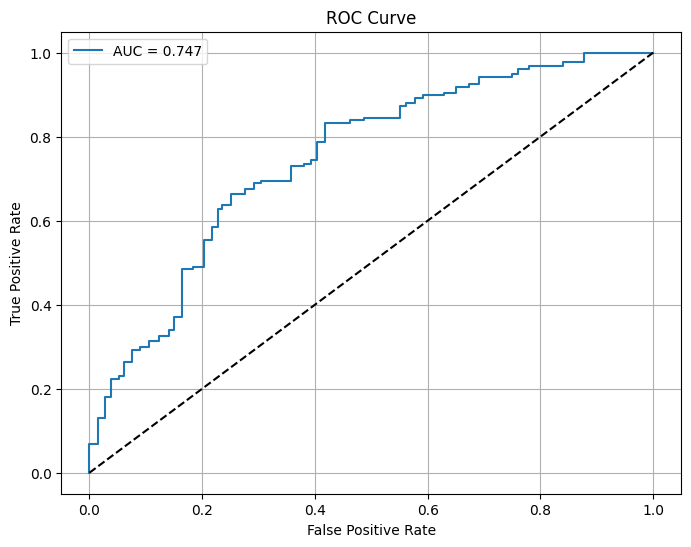

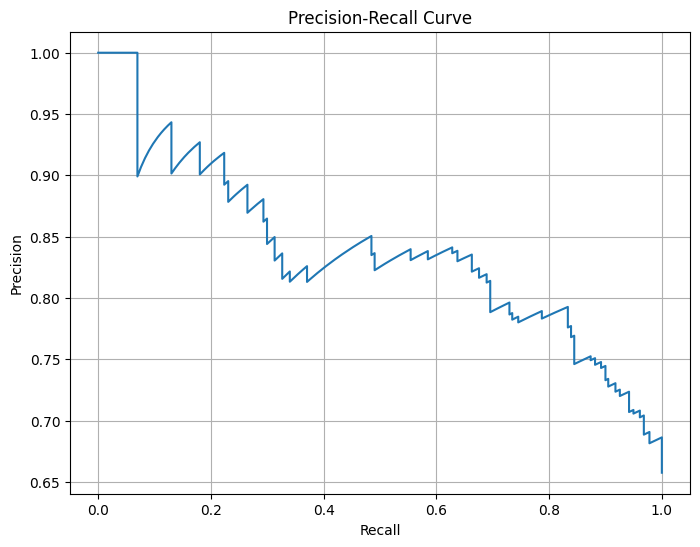

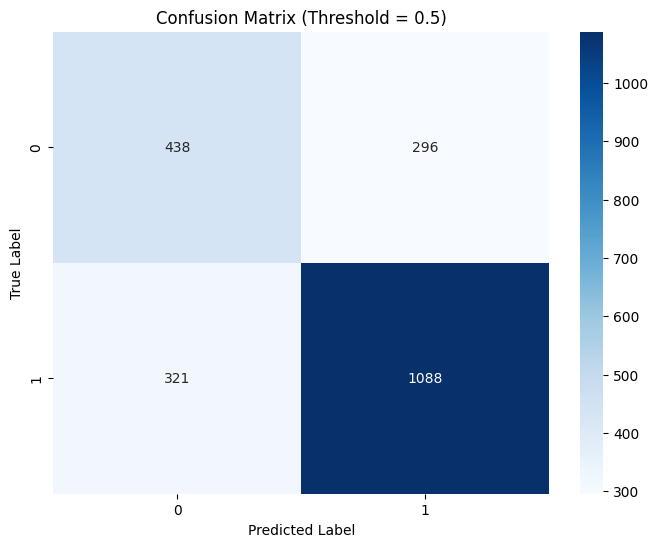

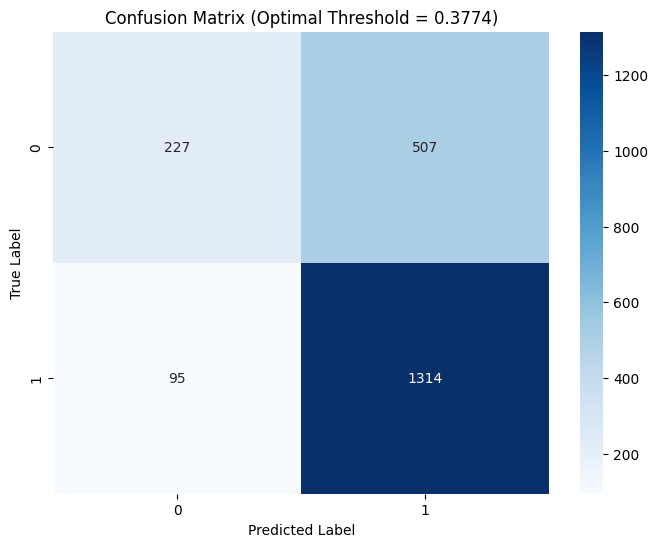

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision import models, transforms
from tqdm.auto import tqdm
import time
import pickle


class FocalLoss(nn.Module):
    """
    Focal Loss for binary classification.
    """
    def __init__(self, alpha=0.5, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# VGG16 FEATURE EXTRACTOR 

class VGG16FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16FeatureExtractor, self).__init__()
        
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)

        for param in self.vgg.features.parameters():
            param.requires_grad = False

        num_vgg_features = self.vgg.features[-3].out_channels  
        self.vgg.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.vgg.classifier = nn.Sequential(
            nn.Linear(num_vgg_features, 512),  
            nn.ReLU(True),
            nn.Dropout(0.5)
        )
        
        for m in self.vgg.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.vgg.features(x)
        x = self.vgg.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.vgg.classifier(x) 
        return x


# VGG16 FULL MODEL WRAPPER 
class VGG16FullModel(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(VGG16FullModel, self).__init__()
        self.extractor = VGG16FeatureExtractor(pretrained=pretrained)
        
        self.final_classifier = nn.Linear(512, num_classes)
        
        nn.init.xavier_normal_(self.final_classifier.weight)
        nn.init.constant_(self.final_classifier.bias, 0)
        
    def forward(self, x):
        x = self.extractor(x)
        x = self.final_classifier(x)
        return x


def create_vgg16_model(num_classes=1, pretrained=True):
    # Instantiate the new full model wrapper
    return VGG16FullModel(num_classes=num_classes, pretrained=pretrained)


cpu_initial_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()          
])


gpu_train_transforms = torch.nn.Sequential(
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

gpu_eval_transforms = torch.nn.Sequential(
    transforms.CenterCrop(224), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


train_dataset = ChestXRayDataset(
    loaded_data['train']['df'],
    loaded_data['train']['image_paths'],
    transform=cpu_initial_transform 

val_dataset = ChestXRayDataset(
    loaded_data['val']['df'],
    loaded_data['val']['image_paths'],
    transform=cpu_initial_transform 

labels = loaded_data['train']['df']['Atelectasis'].values
unique_labels = np.unique(labels)
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in unique_labels])
weight = 1. / class_sample_count
label_to_weight = dict(zip(unique_labels, weight))
samples_weight = np.array([label_to_weight[label] for label in labels])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0, 
    pin_memory=True 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0, 
    pin_memory=True
)


# MODEL, OPTIMIZER, AND SCHEDULER INITIALIZATION

print("\n--- Starting VGG Model Initialization (VGG16 on Atelectasis dataset) ---")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = create_vgg16_model(num_classes=1)
model = model.to(device)

gpu_train_transforms = gpu_train_transforms.to(device)
gpu_eval_transforms = gpu_eval_transforms.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs! Training in parallel.")
    model = nn.DataParallel(model)

criterion = FocalLoss(alpha=0.5, gamma=2.0)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=0.01,
    amsgrad=True
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

# TRAINING AND VALIDATION FUNCTIONS

def train_epoch(model, loader, criterion, optimizer, device, gpu_transforms):
    model.train()
    running_loss = 0.0
    predictions, true_labels = [], []
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        inputs = gpu_transforms(inputs)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions.extend(torch.sigmoid(outputs).cpu().detach().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions).squeeze()
    true_labels = np.array(true_labels)
    pred_labels = (predictions > 0.5).astype(int)
    return (running_loss / len(loader), 
            accuracy_score(true_labels, pred_labels), 
            f1_score(true_labels, pred_labels), 
            roc_auc_score(true_labels, predictions))

def validate(model, loader, criterion, device, gpu_transforms):
    model.eval()
    running_loss = 0.0
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            inputs = gpu_transforms(inputs)
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            running_loss += loss.item()
            predictions.extend(torch.sigmoid(outputs).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions).squeeze()
    true_labels = np.array(true_labels)
    pred_labels = (predictions > 0.5).astype(int)
    return (running_loss / len(loader), 
            accuracy_score(true_labels, pred_labels), 
            f1_score(true_labels, pred_labels), 
            roc_auc_score(true_labels, predictions))

# TRAINING LOOP 

print("\n--- Starting VGG16 Model Training ---")
num_epochs = 20
best_val_auc = 0.0
patience = 5
epochs_no_improve = 0
early_stop = False
UNFREEZE_EPOCH = 4
history = {k: [] for k in ['train_loss', 'train_acc', 'train_f1', 'train_auc', 'val_loss', 'val_acc', 'val_f1', 'val_auc', 'epoch_time']}

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    if early_stop:
        print(f"\nEarly stopping: Validation AUC did not improve for {patience} epochs.")
        break

    if epoch == UNFREEZE_EPOCH:
        print("\n" + "="*50 + f"\nEpoch {epoch+1}: Unfreezing last two convolutional blocks (Block 4 and 5).\n" + "="*50 + "\n")
        
        model_to_unfreeze = model.module if isinstance(model, nn.DataParallel) else model
        

        unfrozen_layers = model_to_unfreeze.extractor.vgg.features[17:]
        
        for param in unfrozen_layers.parameters():
            param.requires_grad = True
            
        params_group_1_features = unfrozen_layers.parameters()
        params_group_2_vgg_head = model_to_unfreeze.extractor.vgg.classifier.parameters()   
        params_group_3_final_head = model_to_unfreeze.final_classifier.parameters()
            
        optimizer = torch.optim.AdamW([
            {'params': params_group_1_features, 'lr': 1e-5}, 
            {'params': list(params_group_2_vgg_head) + list(params_group_3_final_head), 'lr': 1e-4} 
        ], weight_decay=0.01, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    start_time = time.time()
    train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device, gpu_train_transforms)
    val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device, gpu_eval_transforms)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)
    history['epoch_time'].append(time.time() - start_time)

    scheduler.step(val_auc)
    print(f'\nEpoch {epoch+1}/{num_epochs} | Time: {history["epoch_time"][-1]:.2f}s')
    print(f'Training:    Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}')
    print(f'Validation: Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        epochs_no_improve = 0
        print("Saving new best model checkpoint...")
        state_dict_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict_to_save, 'best_Atelectasis_vgg16_model.pth')
        print(f'Saved best model with validation AUC: {val_auc:.4f}')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True


# PLOTTING AND HISTORY STORAGE (Pre-evaluation)

print("\n--- Storing Training History and Plots ---")
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Train vs. Validation Loss'), plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend(), plt.grid(True)
plt.savefig('train_val_loss_plot.png'), plt.show()

with open('Atelectasis_vgg16_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print("\nModel training history saved.")

# FINAL EVALUATION ON TEST SET

print("\n--- Starting Final Evaluation on Test Dataset ---")

# Load best model for evaluation
eval_model = create_vgg16_model()
eval_model.load_state_dict(torch.load('best_Atelectasis_vgg16_model.pth'))
eval_model.to(device)
eval_model.eval()

test_loader = DataLoader(
    ChestXRayDataset(loaded_data['test']['df'], loaded_data['test']['image_paths'], transform=cpu_initial_transform),
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, # Changed from os.cpu_count()
    pin_memory=True
)

y_true, y_prob = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device, non_blocking=True)
        
        inputs = gpu_eval_transforms(inputs)
        
        y_true.extend(labels.numpy())
        outputs = eval_model(inputs)
        y_prob.extend(torch.sigmoid(outputs).cpu().numpy())
y_true, y_prob = np.array(y_true), np.array(y_prob).squeeze()

def bootstrap_metric(y_true, y_pred, metric_func, n_bootstraps=1000):
    """Calculates 95% CI for a given metric using bootstrapping."""
    bootstrapped_scores = []
    rng = np.random.RandomState(42)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    lower_bound = np.percentile(sorted_scores, 2.5)
    upper_bound = np.percentile(sorted_scores, 97.5)
    
    return lower_bound, upper_bound


precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal Threshold found: {best_threshold:.4f}")


y_pred_default = (y_prob > 0.5).astype(int)
y_pred_optimal = (y_prob > best_threshold).astype(int)

evaluation_results = []

auc_score = roc_auc_score(y_true, y_prob)
auc_ci_lower, auc_ci_upper = bootstrap_metric(y_true, y_prob, roc_auc_score)
evaluation_results.append({'Metric': 'AUC', 'Score': auc_score, '95% CI Lower': auc_ci_lower, '95% CI Upper': auc_ci_upper})

metrics_to_calc = {
    "Accuracy": accuracy_score,
    "F1-Score": f1_score,
    "Precision": precision_score,
    "Recall": recall_score
}

for name, func in metrics_to_calc.items():
    score = func(y_true, y_pred_optimal)
    ci_lower, ci_upper = bootstrap_metric(y_true, y_pred_optimal, func)
    evaluation_results.append({'Metric': f'{name} (Optimal)', 'Score': score, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

for name, func in metrics_to_calc.items():
    score = func(y_true, y_pred_default)
    ci_lower, ci_upper = bootstrap_metric(y_true, y_pred_default, func)
    evaluation_results.append({'Metric': f'{name} (Default)', 'Score': score, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

results_df = pd.DataFrame(evaluation_results)
results_df = results_df.set_index('Metric')
print("\n" + "="*50 + "\nFinal Test Set Evaluation Scores\n" + "="*50)
print(results_df)

results_df.to_csv('evaluation_scores_with_ci.csv')
print("\nEvaluation scores saved to 'evaluation_scores_with_ci.csv'")

print("\n--- Plotting Final Confusion Matrices and Curves ---")

print("\nClassification Report (Default Threshold 0.5):")
print(classification_report(y_true, y_pred_default, target_names=['Negative', 'Positive']))
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal, target_names=['Negative', 'Positive']))

def plot_curve(x, y, x_label, y_label, title, file_name, auc_score_val=None):
    plt.figure(figsize=(8, 6))
    label = f'AUC = {auc_score_val:.3f}' if auc_score_val is not None else None
    plt.plot(x, y, label=label)
    if auc_score_val is not None:
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend()
    plt.xlabel(x_label), plt.ylabel(y_label), plt.title(title), plt.grid(True)
    plt.savefig(file_name), plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
plot_curve(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC Curve', 'roc_curve.png', auc_score_val=auc_score)
plot_curve(recall, precision, 'Recall', 'Precision', 'Precision-Recall Curve', 'precision_recall_curve.png')

# Plotting confusion matrices
def plot_confusion_matrix(cm, title, file_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title), plt.ylabel('True Label'), plt.xlabel('Predicted Label')
    plt.savefig(file_name), plt.show()

plot_confusion_matrix(confusion_matrix(y_true, y_pred_default), 'Confusion Matrix (Threshold = 0.5)', 'confusion_matrix_default.png')
plot_confusion_matrix(confusion_matrix(y_true, y_pred_optimal), f'Confusion Matrix (Optimal Threshold = {best_threshold:.4f})', 'confusion_matrix_optimal.png')


# Cardiomegaly

STATISTICAL ANALYSIS FOR CLASS: CARDIOMEGALY
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.

--- TRAIN SET (Cardiomegaly_train.csv) ---
Total entries (Row Count): 5,391

Condition label distribution (per column):
  • Cardiomegaly   :
    - Positive (1) :   3,346 ( 62.1%)
    - Negative (0) :   2,045
    - Total Labeled:   5,391

--- VAL SET (Cardiomegaly_val.csv) ---
Total entries (Row Count): 444

Condition label distribution (per column):
  • Cardiomegaly   :
    - Positive (1) :     268 ( 60.4%)
    - Negative (0) :     176
    - Total Labeled:     444

--- TEST SET (Cardiomegaly_test.csv) ---
Total entries (Row Count): 2,530

Condition label distribution (per column):
  • Cardiomegaly   :
    - Positive (1) :   1,444 ( 57.1%)
    - Negative (0) :   1,086
    - Total Labeled:   2,530

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PLOTTING TRAINING SET L

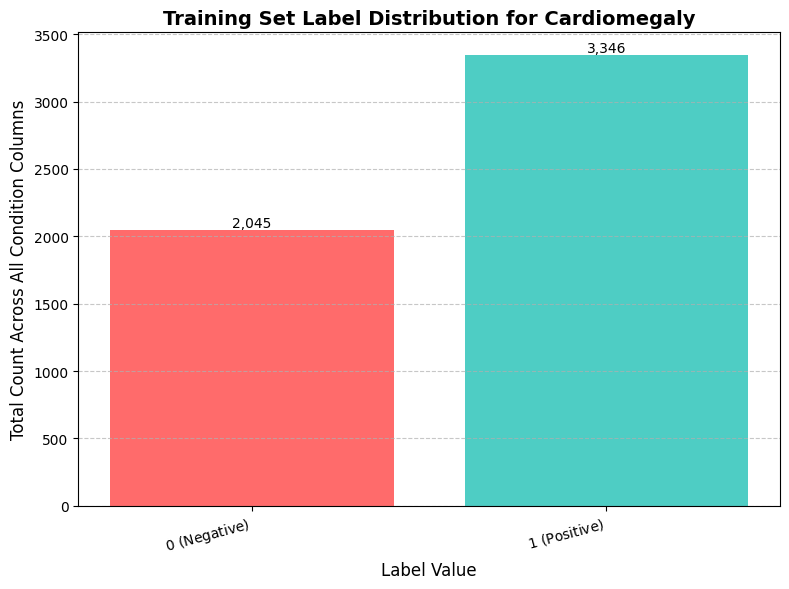

Plot saved as 'cardiomegaly_label_distribution.png'

--- Starting Data Load for Class: Cardiomegaly ---
  Loaded train CSV: 5,391 entries. Verified images: 5,391.
  Loaded val CSV: 444 entries. Verified images: 444.
  Loaded test CSV: 2,530 entries. Verified images: 2,530.
Sucesfully Loaded Dataset


In [7]:
target_class="Cardiomegaly"

train_df_result = analyze_class_csv_stats(class_name=target_class)
visualize_training_label_distribution(class_name=target_class, train_df=train_df_result)
loaded_data = load_dataset(class_name="Cardiomegaly")

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from PIL import Image

# Custom Dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, image_paths, transform=None):
        self.dataframe = dataframe
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Get the label from the dataframe
        df_idx = self.dataframe.index[self.dataframe['cxr_path'].str.contains(os.path.basename(img_path))][0]
        label = torch.tensor(self.dataframe.iloc[df_idx]['Cardiomegaly'], dtype=torch.float32)

        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print ("Cardiomegaly CXR dataset loaded" )

Cardiomegaly CXR dataset loaded



--- Starting VGG Model Initialization (VGG16 on Cardiomegaly dataset) ---
Using 2 GPUs! Training in parallel.

--- Starting VGG16(Cardiomegaly) Model Training ---


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 1/20 | Time: 61.85s
Training:    Loss: 0.0976, Acc: 0.5285, F1: 0.5218, AUC: 0.5552
Validation: Loss: 0.0835, Acc: 0.5856, F1: 0.6017, AUC: 0.6685
Saving new best model checkpoint...
Saved best model with validation AUC: 0.6685


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 2/20 | Time: 58.05s
Training:    Loss: 0.0887, Acc: 0.5891, F1: 0.5976, AUC: 0.6181
Validation: Loss: 0.0809, Acc: 0.6216, F1: 0.6543, AUC: 0.6952
Saving new best model checkpoint...
Saved best model with validation AUC: 0.6952


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 3/20 | Time: 56.71s
Training:    Loss: 0.0843, Acc: 0.6092, F1: 0.6051, AUC: 0.6516
Validation: Loss: 0.0806, Acc: 0.6216, F1: 0.6471, AUC: 0.7019
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7019


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 4/20 | Time: 55.85s
Training:    Loss: 0.0822, Acc: 0.6194, F1: 0.6040, AUC: 0.6677
Validation: Loss: 0.0798, Acc: 0.6194, F1: 0.6472, AUC: 0.7076
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7076

Epoch 5: Unfreezing last two convolutional blocks (Block 4 and 5).



Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 5/20 | Time: 62.44s
Training:    Loss: 0.0801, Acc: 0.6387, F1: 0.6452, AUC: 0.6937
Validation: Loss: 0.0793, Acc: 0.6239, F1: 0.6393, AUC: 0.7267
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7267


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 6/20 | Time: 62.79s
Training:    Loss: 0.0783, Acc: 0.6669, F1: 0.6748, AUC: 0.7205
Validation: Loss: 0.0741, Acc: 0.6644, F1: 0.7276, AUC: 0.7356
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7356


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 7/20 | Time: 61.81s
Training:    Loss: 0.0764, Acc: 0.6754, F1: 0.6873, AUC: 0.7372
Validation: Loss: 0.0717, Acc: 0.7072, F1: 0.7883, AUC: 0.7633
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7633


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 8/20 | Time: 61.89s
Training:    Loss: 0.0768, Acc: 0.6711, F1: 0.6807, AUC: 0.7327
Validation: Loss: 0.0733, Acc: 0.6982, F1: 0.7383, AUC: 0.7595


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 9/20 | Time: 61.70s
Training:    Loss: 0.0754, Acc: 0.6797, F1: 0.6975, AUC: 0.7440
Validation: Loss: 0.0729, Acc: 0.6959, F1: 0.7358, AUC: 0.7712
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7712


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 10/20 | Time: 62.02s
Training:    Loss: 0.0737, Acc: 0.7023, F1: 0.7007, AUC: 0.7617
Validation: Loss: 0.0708, Acc: 0.7095, F1: 0.7561, AUC: 0.7816
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7816


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 11/20 | Time: 62.35s
Training:    Loss: 0.0732, Acc: 0.6995, F1: 0.7176, AUC: 0.7649
Validation: Loss: 0.0716, Acc: 0.6982, F1: 0.7413, AUC: 0.7758


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 12/20 | Time: 62.06s
Training:    Loss: 0.0723, Acc: 0.7069, F1: 0.6995, AUC: 0.7736
Validation: Loss: 0.0736, Acc: 0.6869, F1: 0.7146, AUC: 0.7762


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 13/20 | Time: 61.86s
Training:    Loss: 0.0726, Acc: 0.7014, F1: 0.7200, AUC: 0.7694
Validation: Loss: 0.0716, Acc: 0.7185, F1: 0.7535, AUC: 0.7833
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7833


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 14/20 | Time: 61.73s
Training:    Loss: 0.0713, Acc: 0.7132, F1: 0.7153, AUC: 0.7801
Validation: Loss: 0.0697, Acc: 0.7095, F1: 0.7642, AUC: 0.7774


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 15/20 | Time: 61.70s
Training:    Loss: 0.0718, Acc: 0.7106, F1: 0.7259, AUC: 0.7770
Validation: Loss: 0.0681, Acc: 0.7185, F1: 0.7811, AUC: 0.7859
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7859


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 16/20 | Time: 62.03s
Training:    Loss: 0.0709, Acc: 0.7155, F1: 0.7176, AUC: 0.7848
Validation: Loss: 0.0734, Acc: 0.6959, F1: 0.7146, AUC: 0.7894
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7894


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 17/20 | Time: 62.08s
Training:    Loss: 0.0713, Acc: 0.7099, F1: 0.7221, AUC: 0.7837
Validation: Loss: 0.0740, Acc: 0.6847, F1: 0.6983, AUC: 0.7862


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 18/20 | Time: 61.93s
Training:    Loss: 0.0703, Acc: 0.7279, F1: 0.7328, AUC: 0.7923
Validation: Loss: 0.0680, Acc: 0.7162, F1: 0.7726, AUC: 0.7904
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7904


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 19/20 | Time: 62.02s
Training:    Loss: 0.0689, Acc: 0.7271, F1: 0.7356, AUC: 0.8020
Validation: Loss: 0.0689, Acc: 0.7140, F1: 0.7590, AUC: 0.7919
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7919


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 20/20 | Time: 62.15s
Training:    Loss: 0.0686, Acc: 0.7295, F1: 0.7362, AUC: 0.8038
Validation: Loss: 0.0720, Acc: 0.7117, F1: 0.7322, AUC: 0.7959
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7959

--- Storing Training History and Plots ---


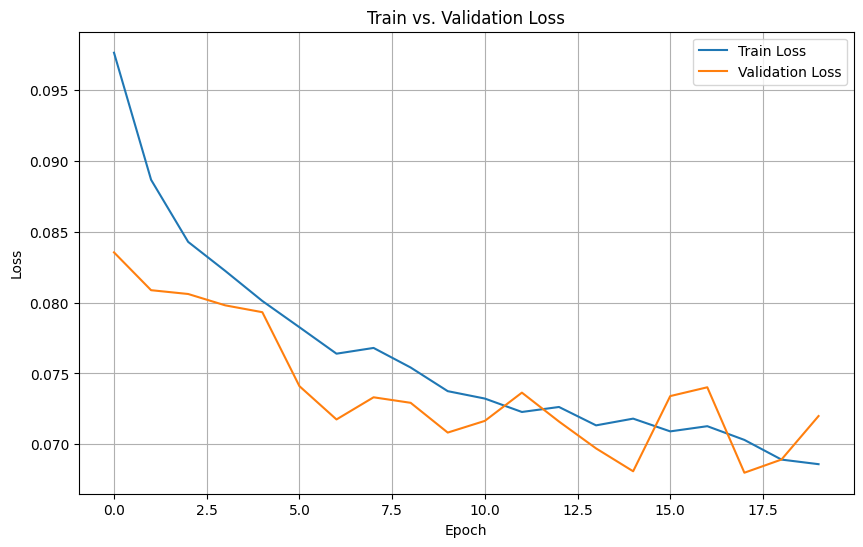


Model training history saved.

--- Starting Final Evaluation on Test Dataset ---


Testing:   0%|          | 0/40 [00:00<?, ?it/s]


Optimal Threshold found: 0.3376

Final Test Set Evaluation Scores
                        Score  95% CI Lower  95% CI Upper
Metric                                                   
AUC                  0.727714      0.707703      0.747896
Accuracy (Optimal)   0.675099      0.656126      0.693686
F1-Score (Optimal)   0.766345      0.751137      0.782164
Precision (Optimal)  0.649952      0.630866      0.670510
Recall (Optimal)     0.933518      0.920054      0.945442
Accuracy (Default)   0.632411      0.612648      0.651779
F1-Score (Default)   0.647460      0.624705      0.668928
Precision (Default)  0.715243      0.689419      0.743144
Recall (Default)     0.591413      0.565451      0.617095

Evaluation scores saved to 'Cardiomegaly evaluation_scores_with_ci.csv'

--- Plotting Final Confusion Matrices and Curves ---

Cardiomegaly Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

    Negative       0.56      0.69      0.62      108

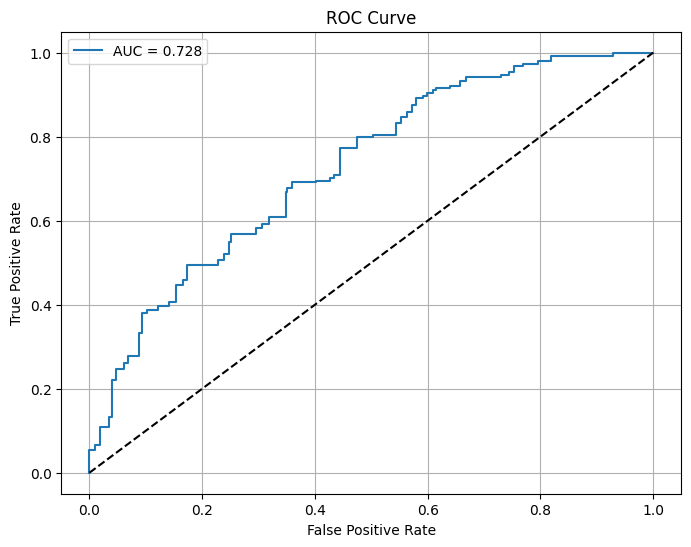

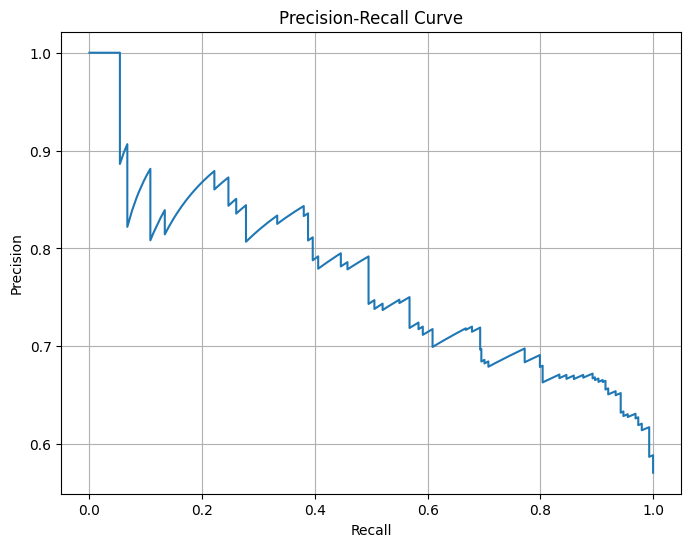

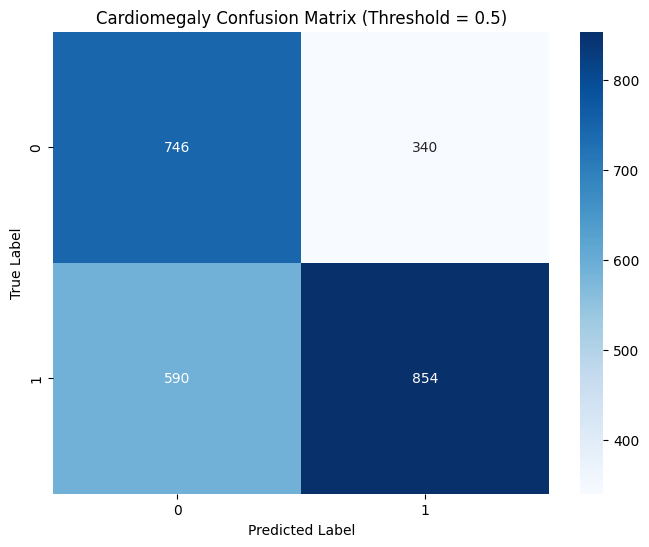

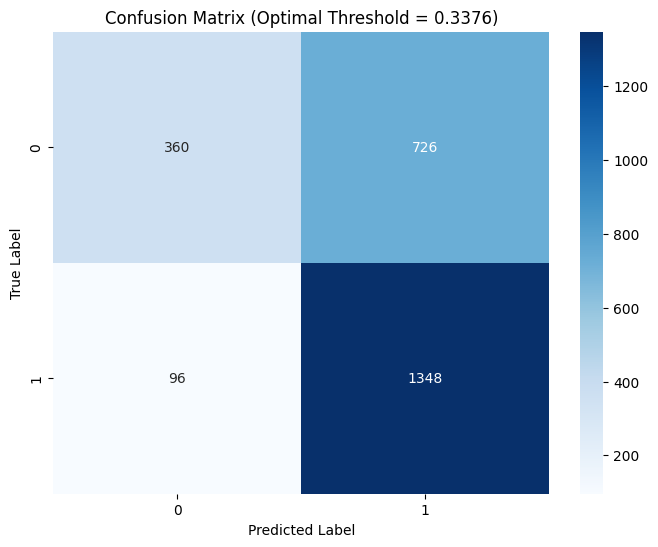

In [10]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision import models, transforms
from tqdm.auto import tqdm
import time
import pickle


class FocalLoss(nn.Module):
    """
    Focal Loss for binary classification.
    """
    def __init__(self, alpha=0.5, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# VGG16 FEATURE EXTRACTOR 

class VGG16FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16FeatureExtractor, self).__init__()
        
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)

        for param in self.vgg.features.parameters():
            param.requires_grad = False

        num_vgg_features = self.vgg.features[-3].out_channels  
        self.vgg.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.vgg.classifier = nn.Sequential(
            nn.Linear(num_vgg_features, 512),  
            nn.ReLU(True),
            nn.Dropout(0.5)
        )
        
        for m in self.vgg.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.vgg.features(x)
        x = self.vgg.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.vgg.classifier(x) 
        return x


# VGG16 FULL MODEL WRAPPER 
class VGG16FullModel(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(VGG16FullModel, self).__init__()
        self.extractor = VGG16FeatureExtractor(pretrained=pretrained)
        
        self.final_classifier = nn.Linear(512, num_classes)
        
        nn.init.xavier_normal_(self.final_classifier.weight)
        nn.init.constant_(self.final_classifier.bias, 0)
        
    def forward(self, x):
        x = self.extractor(x)
        x = self.final_classifier(x)
        return x

# VGG16 MODEL DEFINITION AND CONFIGURATION 

def create_vgg16_model(num_classes=1, pretrained=True):
    return VGG16FullModel(num_classes=num_classes, pretrained=pretrained)


cpu_initial_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor()         
])


gpu_train_transforms = torch.nn.Sequential(
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

gpu_eval_transforms = torch.nn.Sequential(
    transforms.CenterCrop(224), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


train_dataset = ChestXRayDataset(
    loaded_data['train']['df'],
    loaded_data['train']['image_paths'],
    transform=cpu_initial_transform 
)

val_dataset = ChestXRayDataset(
    loaded_data['val']['df'],
    loaded_data['val']['image_paths'],
    transform=cpu_initial_transform 
)

labels = loaded_data['train']['df']['Cardiomegaly'].values
unique_labels = np.unique(labels)
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in unique_labels])
weight = 1. / class_sample_count
label_to_weight = dict(zip(unique_labels, weight))
samples_weight = np.array([label_to_weight[label] for label in labels])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0, 
    pin_memory=True 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0, 
    pin_memory=True
)

# MODEL, OPTIMIZER, AND SCHEDULER INITIALIZATION

print("\n--- Starting VGG Model Initialization (VGG16 on Cardiomegaly dataset) ---")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = create_vgg16_model(num_classes=1)
model = model.to(device)

gpu_train_transforms = gpu_train_transforms.to(device)
gpu_eval_transforms = gpu_eval_transforms.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs! Training in parallel.")
    model = nn.DataParallel(model)

criterion = FocalLoss(alpha=0.5, gamma=2.0)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=0.01,
    amsgrad=True
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)


def train_epoch(model, loader, criterion, optimizer, device, gpu_transforms):
    model.train()
    running_loss = 0.0
    predictions, true_labels = [], []
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        inputs = gpu_transforms(inputs)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions.extend(torch.sigmoid(outputs).cpu().detach().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions).squeeze()
    true_labels = np.array(true_labels)
    pred_labels = (predictions > 0.5).astype(int)
    return (running_loss / len(loader), 
            accuracy_score(true_labels, pred_labels), 
            f1_score(true_labels, pred_labels), 
            roc_auc_score(true_labels, predictions))

def validate(model, loader, criterion, device, gpu_transforms):
    model.eval()
    running_loss = 0.0
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            inputs = gpu_transforms(inputs)
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            running_loss += loss.item()
            predictions.extend(torch.sigmoid(outputs).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions).squeeze()
    true_labels = np.array(true_labels)
    pred_labels = (predictions > 0.5).astype(int)
    return (running_loss / len(loader), 
            accuracy_score(true_labels, pred_labels), 
            f1_score(true_labels, pred_labels), 
            roc_auc_score(true_labels, predictions))


print("\n--- Starting VGG16(Cardiomegaly) Model Training ---")
num_epochs = 20
best_val_auc = 0.0
patience = 5
epochs_no_improve = 0
early_stop = False
UNFREEZE_EPOCH = 4
history = {k: [] for k in ['train_loss', 'train_acc', 'train_f1', 'train_auc', 'val_loss', 'val_acc', 'val_f1', 'val_auc', 'epoch_time']}

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    if early_stop:
        print(f"\nEarly stopping: Validation AUC did not improve for {patience} epochs.")
        break

    if epoch == UNFREEZE_EPOCH:
        print("\n" + "="*50 + f"\nEpoch {epoch+1}: Unfreezing last two convolutional blocks (Block 4 and 5).\n" + "="*50 + "\n")
        
        model_to_unfreeze = model.module if isinstance(model, nn.DataParallel) else model
        
      
        unfrozen_layers = model_to_unfreeze.extractor.vgg.features[17:]
        
        for param in unfrozen_layers.parameters():
            param.requires_grad = True
            
        params_group_1_features = unfrozen_layers.parameters()
        params_group_2_vgg_head = model_to_unfreeze.extractor.vgg.classifier.parameters()   
        params_group_3_final_head = model_to_unfreeze.final_classifier.parameters()
            
        optimizer = torch.optim.AdamW([
            {'params': params_group_1_features, 'lr': 1e-5}, 
            {'params': list(params_group_2_vgg_head) + list(params_group_3_final_head), 'lr': 1e-4} 
        ], weight_decay=0.01, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    start_time = time.time()
    train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device, gpu_train_transforms)
    val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device, gpu_eval_transforms)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)
    history['epoch_time'].append(time.time() - start_time)

    scheduler.step(val_auc)
    print(f'\nEpoch {epoch+1}/{num_epochs} | Time: {history["epoch_time"][-1]:.2f}s')
    print(f'Training:    Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}')
    print(f'Validation: Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        epochs_no_improve = 0
        print("Saving new best model checkpoint...")
        state_dict_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict_to_save, 'best_Cardiomegaly_vgg16_model.pth')
        print(f'Saved best model with validation AUC: {val_auc:.4f}')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

# PLOTTING AND HISTORY STORAGE (Pre-evaluation)

print("\n--- Storing Training History and Plots ---")
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Train vs. Validation Loss'), plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend(), plt.grid(True)
plt.savefig('Cardiomegaly train_val_loss_plot.png'), plt.show()

with open('Cardiomegaly_vgg16_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print("\nModel training history saved.")

# FINAL EVALUATION ON TEST SET

print("\n--- Starting Final Evaluation on Test Dataset ---")

# Load best model for evaluation
eval_model = create_vgg16_model()
eval_model.load_state_dict(torch.load('best_Cardiomegaly_vgg16_model.pth'))
eval_model.to(device)
eval_model.eval()

test_loader = DataLoader(
    ChestXRayDataset(loaded_data['test']['df'], loaded_data['test']['image_paths'], transform=cpu_initial_transform),
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

y_true, y_prob = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device, non_blocking=True)
        
        inputs = gpu_eval_transforms(inputs)
        
        y_true.extend(labels.numpy())
        outputs = eval_model(inputs)
        y_prob.extend(torch.sigmoid(outputs).cpu().numpy())
y_true, y_prob = np.array(y_true), np.array(y_prob).squeeze()

def bootstrap_metric(y_true, y_pred, metric_func, n_bootstraps=1000):
    """Calculates 95% CI for a given metric using bootstrapping."""
    bootstrapped_scores = []
    rng = np.random.RandomState(42)
    for i in range(n_bootstraps):
        # Sample with replacement
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # Avoid cases where a bootstrap sample has only one class
            continue
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    # Calculate 95% confidence interval
    lower_bound = np.percentile(sorted_scores, 2.5)
    upper_bound = np.percentile(sorted_scores, 97.5)
    
    return lower_bound, upper_bound

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal Threshold found: {best_threshold:.4f}")


# Prepare predictions based on both thresholds
y_pred_default = (y_prob > 0.5).astype(int)
y_pred_optimal = (y_prob > best_threshold).astype(int)

# Store results
evaluation_results = []

# 1. AUC Score (threshold-independent)
auc_score = roc_auc_score(y_true, y_prob)
auc_ci_lower, auc_ci_upper = bootstrap_metric(y_true, y_prob, roc_auc_score)
evaluation_results.append({'Metric': 'AUC', 'Score': auc_score, '95% CI Lower': auc_ci_lower, '95% CI Upper': auc_ci_upper})

# 2. Metrics for Optimal Threshold
metrics_to_calc = {
    "Accuracy": accuracy_score,
    "F1-Score": f1_score,
    "Precision": precision_score,
    "Recall": recall_score
}

for name, func in metrics_to_calc.items():
    score = func(y_true, y_pred_optimal)
    ci_lower, ci_upper = bootstrap_metric(y_true, y_pred_optimal, func)
    evaluation_results.append({'Metric': f'{name} (Optimal)', 'Score': score, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

# 3. Metrics for Default Threshold (0.5)
for name, func in metrics_to_calc.items():
    score = func(y_true, y_pred_default)
    ci_lower, ci_upper = bootstrap_metric(y_true, y_pred_default, func)
    evaluation_results.append({'Metric': f'{name} (Default)', 'Score': score, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

# Create and save DataFrame
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.set_index('Metric')
print("\n" + "="*50 + "\nFinal Test Set Evaluation Scores\n" + "="*50)
print(results_df)

# Save to CSV
results_df.to_csv('evaluation_scores_with_ci.csv')
print("\nEvaluation scores saved to 'Cardiomegaly evaluation_scores_with_ci.csv'")

# --- PLOTTING FINAL RESULTS ---
print("\n--- Plotting Final Confusion Matrices and Curves ---")

# Classification reports
print("\nCardiomegaly Classification Report (Default Threshold 0.5):")
print(classification_report(y_true, y_pred_default, target_names=['Negative', 'Positive']))
print("\nCardiomegaly Classification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal, target_names=['Negative', 'Positive']))

# Plotting curves
def plot_curve(x, y, x_label, y_label, title, file_name, auc_score_val=None):
    plt.figure(figsize=(8, 6))
    label = f'AUC = {auc_score_val:.3f}' if auc_score_val is not None else None
    plt.plot(x, y, label=label)
    if auc_score_val is not None:
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend()
    plt.xlabel(x_label), plt.ylabel(y_label), plt.title(title), plt.grid(True)
    plt.savefig(file_name), plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
plot_curve(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC Curve', 'Cardiomegaly roc_curve.png', auc_score_val=auc_score)
plot_curve(recall, precision, 'Recall', 'Precision', 'Precision-Recall Curve', 'Cardiomegaly precision_recall_curve.png')

# Plotting confusion matrices
def plot_confusion_matrix(cm, title, file_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title), plt.ylabel('True Label'), plt.xlabel('Predicted Label')
    plt.savefig(file_name), plt.show()

plot_confusion_matrix(confusion_matrix(y_true, y_pred_default), 'Cardiomegaly Confusion Matrix (Threshold = 0.5)', 'Cardiomegaly confusion_matrix_default.png')
plot_confusion_matrix(confusion_matrix(y_true, y_pred_optimal), f'Confusion Matrix (Optimal Threshold = {best_threshold:.4f})', 'Cardiomegaly confusion_matrix_optimal.png')


# Edema

STATISTICAL ANALYSIS FOR CLASS: EDEMA

--- TRAIN SET (Edema_train.csv) ---
Total entries (Row Count): 4,968

Condition label distribution (per column):
  • Edema          :
    - Positive (1) :   2,067 ( 41.6%)
    - Negative (0) :   2,901
    - Total Labeled:   4,968

--- VAL SET (Edema_val.csv) ---
Total entries (Row Count): 391

Condition label distribution (per column):
  • Edema          :
    - Positive (1) :     148 ( 37.9%)
    - Negative (0) :     243
    - Total Labeled:     391

--- TEST SET (Edema_test.csv) ---
Total entries (Row Count): 2,230

Condition label distribution (per column):
  • Edema          :
    - Positive (1) :     801 ( 35.9%)
    - Negative (0) :   1,429
    - Total Labeled:   2,230

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PLOTTING TRAINING SET LABEL DISTRIBUTION FOR: EDEMA
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Training Set total label counts: 
0.0    2901
1.0    2067


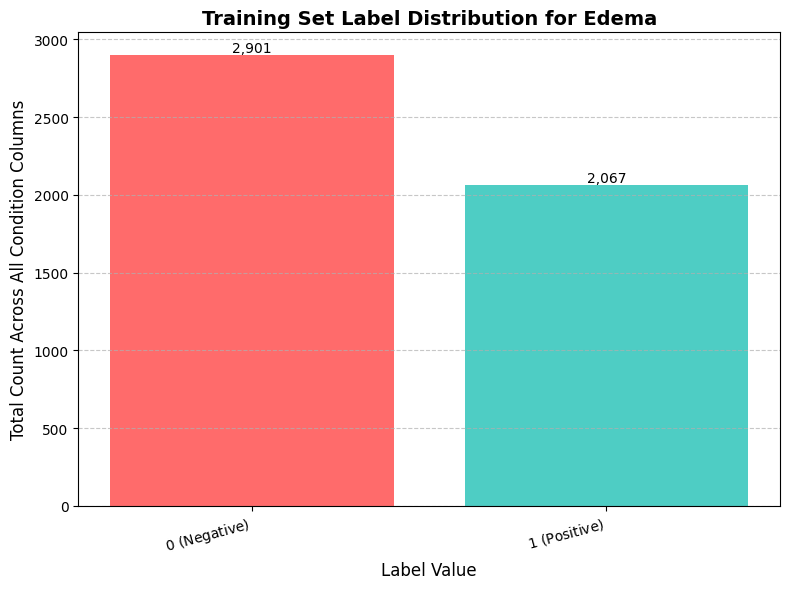

Plot saved as 'edema_label_distribution.png'

--- Starting Data Load for Class: Edema ---
  Loaded train CSV: 4,968 entries. Verified images: 4,968.
  Loaded val CSV: 391 entries. Verified images: 391.
  Loaded test CSV: 2,230 entries. Verified images: 2,230.
Sucesfully Loaded Dataset


In [4]:
target_class="Edema"

train_df_result = analyze_class_csv_stats(class_name=target_class)
visualize_training_label_distribution(class_name=target_class, train_df=train_df_result)
loaded_data = load_dataset(class_name="Edema")

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from PIL import Image

# Custom Dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, image_paths, transform=None):
        self.dataframe = dataframe
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Get the label from the dataframe
        df_idx = self.dataframe.index[self.dataframe['cxr_path'].str.contains(os.path.basename(img_path))][0]
        label = torch.tensor(self.dataframe.iloc[df_idx]['Edema'], dtype=torch.float32)

        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print ("Edema CXR dataset loaded" )

Edema CXR dataset loaded



--- Starting VGG Model Initialization (VGG16 on Edema dataset) ---


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 169MB/s]  


Using 2 GPUs! Training in parallel.

--- Starting VGG16(Edema) Model Training ---


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 1/20 | Time: 81.66s
Training:    Loss: 0.0898, Acc: 0.5702, F1: 0.5707, AUC: 0.6013
Validation: Loss: 0.0742, Acc: 0.6701, F1: 0.6006, AUC: 0.7526
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7526


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 2/20 | Time: 58.30s
Training:    Loss: 0.0818, Acc: 0.6383, F1: 0.6487, AUC: 0.6817
Validation: Loss: 0.0703, Acc: 0.6957, F1: 0.5939, AUC: 0.7715
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7715


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 3/20 | Time: 52.29s
Training:    Loss: 0.0781, Acc: 0.6649, F1: 0.6671, AUC: 0.7224
Validation: Loss: 0.0699, Acc: 0.6957, F1: 0.6510, AUC: 0.7912
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7912


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 4/20 | Time: 51.82s
Training:    Loss: 0.0763, Acc: 0.6743, F1: 0.6819, AUC: 0.7391
Validation: Loss: 0.0678, Acc: 0.7136, F1: 0.6433, AUC: 0.7958
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7958

Epoch 5: Unfreezing last two convolutional blocks (Block 4 and 5).



Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 5/20 | Time: 56.95s
Training:    Loss: 0.0726, Acc: 0.7037, F1: 0.7102, AUC: 0.7720
Validation: Loss: 0.0647, Acc: 0.7596, F1: 0.7219, AUC: 0.8239
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8239


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 6/20 | Time: 55.76s
Training:    Loss: 0.0672, Acc: 0.7452, F1: 0.7436, AUC: 0.8151
Validation: Loss: 0.0609, Acc: 0.7749, F1: 0.7197, AUC: 0.8364
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8364


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 7/20 | Time: 56.18s
Training:    Loss: 0.0647, Acc: 0.7556, F1: 0.7654, AUC: 0.8317
Validation: Loss: 0.0594, Acc: 0.7928, F1: 0.7445, AUC: 0.8579
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8579


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 8/20 | Time: 56.39s
Training:    Loss: 0.0633, Acc: 0.7693, F1: 0.7644, AUC: 0.8444
Validation: Loss: 0.0595, Acc: 0.7877, F1: 0.7446, AUC: 0.8573


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 9/20 | Time: 56.26s
Training:    Loss: 0.0626, Acc: 0.7707, F1: 0.7708, AUC: 0.8452
Validation: Loss: 0.0568, Acc: 0.8031, F1: 0.7508, AUC: 0.8661
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8661


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 10/20 | Time: 56.69s
Training:    Loss: 0.0620, Acc: 0.7657, F1: 0.7630, AUC: 0.8486
Validation: Loss: 0.0580, Acc: 0.7980, F1: 0.7613, AUC: 0.8629


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 11/20 | Time: 57.24s
Training:    Loss: 0.0580, Acc: 0.7868, F1: 0.7979, AUC: 0.8680
Validation: Loss: 0.0603, Acc: 0.7903, F1: 0.7630, AUC: 0.8689
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8689


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 12/20 | Time: 57.72s
Training:    Loss: 0.0589, Acc: 0.7886, F1: 0.7885, AUC: 0.8664
Validation: Loss: 0.0563, Acc: 0.8133, F1: 0.7740, AUC: 0.8690
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8690


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 13/20 | Time: 57.35s
Training:    Loss: 0.0590, Acc: 0.7921, F1: 0.7958, AUC: 0.8666
Validation: Loss: 0.0542, Acc: 0.7903, F1: 0.7230, AUC: 0.8732
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8732


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 14/20 | Time: 57.46s
Training:    Loss: 0.0590, Acc: 0.7840, F1: 0.7831, AUC: 0.8663
Validation: Loss: 0.0602, Acc: 0.7749, F1: 0.7514, AUC: 0.8694


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 15/20 | Time: 57.47s
Training:    Loss: 0.0581, Acc: 0.7917, F1: 0.7930, AUC: 0.8713
Validation: Loss: 0.0540, Acc: 0.8056, F1: 0.7467, AUC: 0.8743
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8743


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 16/20 | Time: 58.02s
Training:    Loss: 0.0584, Acc: 0.7874, F1: 0.7950, AUC: 0.8689
Validation: Loss: 0.0546, Acc: 0.8056, F1: 0.7625, AUC: 0.8753
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8753


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 17/20 | Time: 59.60s
Training:    Loss: 0.0571, Acc: 0.7973, F1: 0.8040, AUC: 0.8763
Validation: Loss: 0.0553, Acc: 0.8107, F1: 0.7771, AUC: 0.8748


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 18/20 | Time: 57.02s
Training:    Loss: 0.0564, Acc: 0.7975, F1: 0.7957, AUC: 0.8793
Validation: Loss: 0.0605, Acc: 0.7724, F1: 0.7521, AUC: 0.8770
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8770


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 19/20 | Time: 56.88s
Training:    Loss: 0.0573, Acc: 0.7987, F1: 0.8003, AUC: 0.8751
Validation: Loss: 0.0544, Acc: 0.8082, F1: 0.7761, AUC: 0.8802
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8802


Training:   0%|          | 0/78 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 20/20 | Time: 57.07s
Training:    Loss: 0.0542, Acc: 0.8003, F1: 0.8072, AUC: 0.8871
Validation: Loss: 0.0562, Acc: 0.8082, F1: 0.7720, AUC: 0.8774

--- Storing Training History and Plots ---


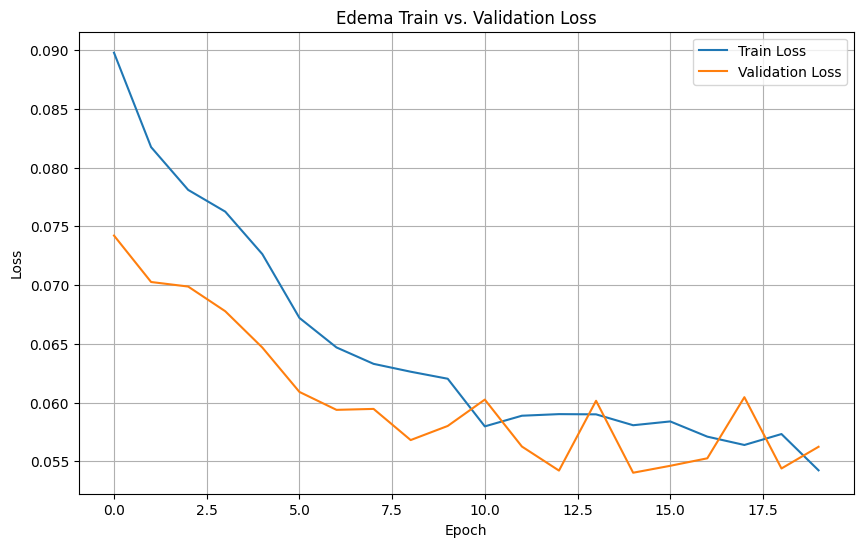


Model training history saved.

--- Starting Final Evaluation on Test Dataset ---


Testing:   0%|          | 0/35 [00:00<?, ?it/s]


Optimal Threshold found: 0.5918

Final Test Set Evaluation Scores
                        Score  95% CI Lower  95% CI Upper
Metric                                                   
AUC                  0.904508      0.889618      0.917675
Accuracy (Optimal)   0.859641      0.843946      0.873991
F1-Score (Optimal)   0.785469      0.760849      0.808595
Precision (Optimal)  0.870821      0.842576      0.897404
Recall (Optimal)     0.715356      0.683757      0.745327
Accuracy (Default)   0.801794      0.783408      0.818386
F1-Score (Default)   0.748005      0.722997      0.770004
Precision (Default)  0.688353      0.655784      0.716824
Recall (Default)     0.818976      0.789910      0.846717

Evaluation scores saved to 'Cardiomegaly evaluation_scores_with_ci.csv'

--- Plotting Final Confusion Matrices and Curves ---

Cardiomegaly Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

    Negative       0.89      0.79      0.84      142

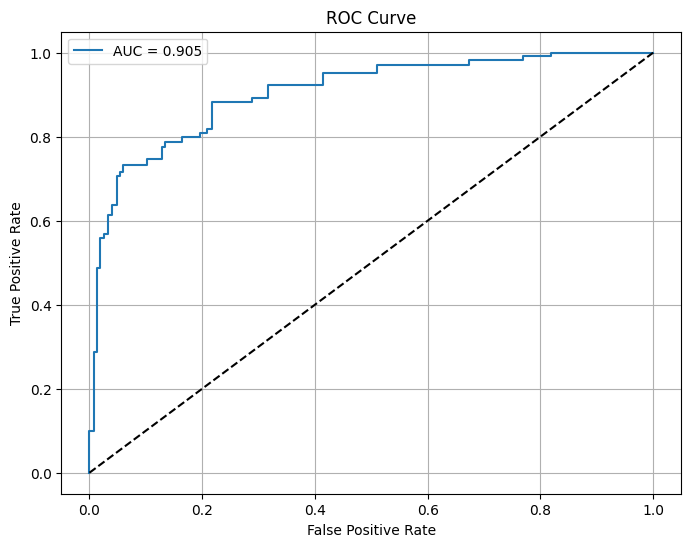

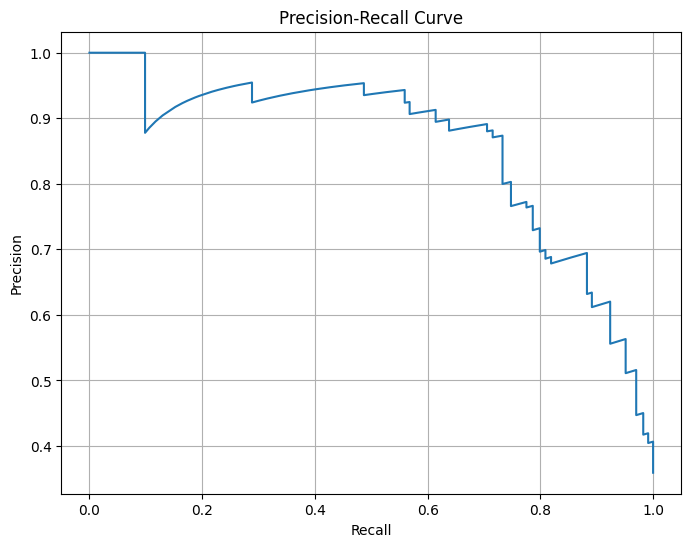

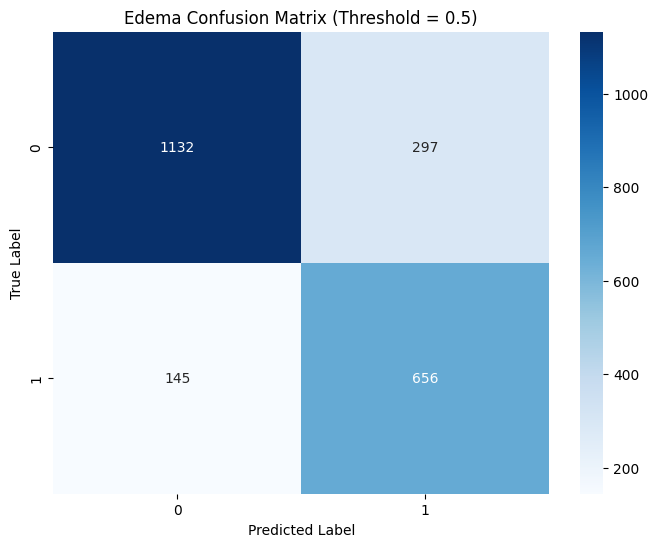

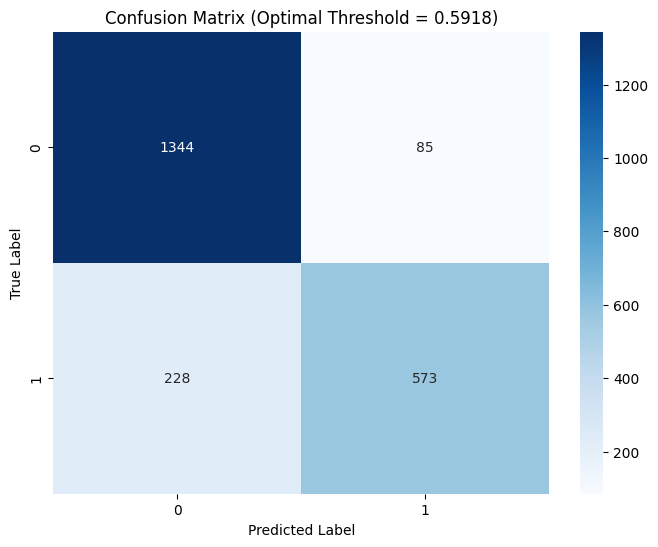

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision import models, transforms
from tqdm.auto import tqdm
import time
import pickle


class FocalLoss(nn.Module):
    """
    Focal Loss for binary classification.
    """
    def __init__(self, alpha=0.5, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# VGG16 FEATURE EXTRACTOR 

class VGG16FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16FeatureExtractor, self).__init__()
        
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)

        for param in self.vgg.features.parameters():
            param.requires_grad = False

        num_vgg_features = self.vgg.features[-3].out_channels  
        self.vgg.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.vgg.classifier = nn.Sequential(
            nn.Linear(num_vgg_features, 512),  
            nn.ReLU(True),
            nn.Dropout(0.5)
        )
        
        for m in self.vgg.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.vgg.features(x)
        x = self.vgg.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.vgg.classifier(x) 
        return x

# VGG16 FULL MODEL WRAPPER 

class VGG16FullModel(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(VGG16FullModel, self).__init__()
        self.extractor = VGG16FeatureExtractor(pretrained=pretrained)
        
        self.final_classifier = nn.Linear(512, num_classes)
        
        nn.init.xavier_normal_(self.final_classifier.weight)
        nn.init.constant_(self.final_classifier.bias, 0)
        
    def forward(self, x):
        x = self.extractor(x)
        x = self.final_classifier(x)
        return x

def create_vgg16_model(num_classes=1, pretrained=True):
    return VGG16FullModel(num_classes=num_classes, pretrained=pretrained)

# DATA TRANSFORMS, SAMPLER, AND DATALOADERS

cpu_initial_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor()         
])


gpu_train_transforms = torch.nn.Sequential(
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

gpu_eval_transforms = torch.nn.Sequential(
    transforms.CenterCrop(224), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


train_dataset = ChestXRayDataset(
    loaded_data['train']['df'],
    loaded_data['train']['image_paths'],
    transform=cpu_initial_transform 
)

val_dataset = ChestXRayDataset(
    loaded_data['val']['df'],
    loaded_data['val']['image_paths'],
    transform=cpu_initial_transform 
)

labels = loaded_data['train']['df']['Edema'].values
unique_labels = np.unique(labels)
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in unique_labels])
weight = 1. / class_sample_count
label_to_weight = dict(zip(unique_labels, weight))
samples_weight = np.array([label_to_weight[label] for label in labels])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0, 
    pin_memory=True 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0, # Changed from os.cpu_count()
    pin_memory=True
)

# MODEL, OPTIMIZER, AND SCHEDULER INITIALIZATION

print("\n--- Starting VGG Model Initialization (VGG16 on Edema dataset) ---")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Use the updated model creation function
model = create_vgg16_model(num_classes=1)
model = model.to(device)


gpu_train_transforms = gpu_train_transforms.to(device)
gpu_eval_transforms = gpu_eval_transforms.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs! Training in parallel.")
    model = nn.DataParallel(model)


criterion = FocalLoss(alpha=0.5, gamma=2.0)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=0.01,
    amsgrad=True
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)


# TRAINING AND VALIDATION FUNCTIONS

def train_epoch(model, loader, criterion, optimizer, device, gpu_transforms):
    model.train()
    running_loss = 0.0
    predictions, true_labels = [], []
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        inputs = gpu_transforms(inputs)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions.extend(torch.sigmoid(outputs).cpu().detach().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions).squeeze()
    true_labels = np.array(true_labels)
    pred_labels = (predictions > 0.5).astype(int)
    return (running_loss / len(loader), 
            accuracy_score(true_labels, pred_labels), 
            f1_score(true_labels, pred_labels), 
            roc_auc_score(true_labels, predictions))

def validate(model, loader, criterion, device, gpu_transforms):
    model.eval()
    running_loss = 0.0
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # --- NEW: Apply transforms on the GPU ---
            inputs = gpu_transforms(inputs)
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            running_loss += loss.item()
            predictions.extend(torch.sigmoid(outputs).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions).squeeze()
    true_labels = np.array(true_labels)
    pred_labels = (predictions > 0.5).astype(int)
    return (running_loss / len(loader), 
            accuracy_score(true_labels, pred_labels), 
            f1_score(true_labels, pred_labels), 
            roc_auc_score(true_labels, predictions))


# TRAINING LOOP

print("\n--- Starting VGG16(Edema) Model Training ---")
num_epochs = 20
best_val_auc = 0.0
patience = 5
epochs_no_improve = 0
early_stop = False
UNFREEZE_EPOCH = 4
history = {k: [] for k in ['train_loss', 'train_acc', 'train_f1', 'train_auc', 'val_loss', 'val_acc', 'val_f1', 'val_auc', 'epoch_time']}

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    if early_stop:
        print(f"\nEarly stopping: Validation AUC did not improve for {patience} epochs.")
        break

    if epoch == UNFREEZE_EPOCH:
        print("\n" + "="*50 + f"\nEpoch {epoch+1}: Unfreezing last two convolutional blocks (Block 4 and 5).\n" + "="*50 + "\n")
        
        model_to_unfreeze = model.module if isinstance(model, nn.DataParallel) else model
        
        
        unfrozen_layers = model_to_unfreeze.extractor.vgg.features[17:]
        
        for param in unfrozen_layers.parameters():
            param.requires_grad = True
            
        params_group_1_features = unfrozen_layers.parameters()
        params_group_2_vgg_head = model_to_unfreeze.extractor.vgg.classifier.parameters()   
        params_group_3_final_head = model_to_unfreeze.final_classifier.parameters()
            
        optimizer = torch.optim.AdamW([
            {'params': params_group_1_features, 'lr': 1e-5}, 
            {'params': list(params_group_2_vgg_head) + list(params_group_3_final_head), 'lr': 1e-4} 
        ], weight_decay=0.01, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    start_time = time.time()
    train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device, gpu_train_transforms)
    val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device, gpu_eval_transforms)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)
    history['epoch_time'].append(time.time() - start_time)

    scheduler.step(val_auc)
    print(f'\nEpoch {epoch+1}/{num_epochs} | Time: {history["epoch_time"][-1]:.2f}s')
    print(f'Training:    Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}')
    print(f'Validation: Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        epochs_no_improve = 0
        print("Saving new best model checkpoint...")
        state_dict_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict_to_save, 'best_Edema_vgg16_model.pth')
        print(f'Saved best model with validation AUC: {val_auc:.4f}')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True


# PLOTTING AND HISTORY STORAGE (Pre-evaluation)

print("\n--- Storing Training History and Plots ---")
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Edema Train vs. Validation Loss'), plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend(), plt.grid(True)
plt.savefig('Edema train_val_loss_plot.png'), plt.show()

with open('Edema_vgg16_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print("\nModel training history saved.")


# FINAL EVALUATION ON TEST SET
print("\n--- Starting Final Evaluation on Test Dataset ---")

# Load best model for evaluation
eval_model = create_vgg16_model()
eval_model.load_state_dict(torch.load('best_Edema_vgg16_model.pth'))
eval_model.to(device)
eval_model.eval()

test_loader = DataLoader(
    ChestXRayDataset(loaded_data['test']['df'], loaded_data['test']['image_paths'], transform=cpu_initial_transform),
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
)

y_true, y_prob = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device, non_blocking=True)
        
        inputs = gpu_eval_transforms(inputs)
        
        y_true.extend(labels.numpy())
        outputs = eval_model(inputs)
        y_prob.extend(torch.sigmoid(outputs).cpu().numpy())
y_true, y_prob = np.array(y_true), np.array(y_prob).squeeze()

def bootstrap_metric(y_true, y_pred, metric_func, n_bootstraps=1000):
    """Calculates 95% CI for a given metric using bootstrapping."""
    bootstrapped_scores = []
    rng = np.random.RandomState(42)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    # Calculate 95% confidence interval
    lower_bound = np.percentile(sorted_scores, 2.5)
    upper_bound = np.percentile(sorted_scores, 97.5)
    
    return lower_bound, upper_bound


# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal Threshold found: {best_threshold:.4f}")


# Prepare predictions based on both thresholds
y_pred_default = (y_prob > 0.5).astype(int)
y_pred_optimal = (y_prob > best_threshold).astype(int)

# Store results
evaluation_results = []

# 1. AUC Score (threshold-independent)
auc_score = roc_auc_score(y_true, y_prob)
auc_ci_lower, auc_ci_upper = bootstrap_metric(y_true, y_prob, roc_auc_score)
evaluation_results.append({'Metric': 'AUC', 'Score': auc_score, '95% CI Lower': auc_ci_lower, '95% CI Upper': auc_ci_upper})

# 2. Metrics for Optimal Threshold
metrics_to_calc = {
    "Accuracy": accuracy_score,
    "F1-Score": f1_score,
    "Precision": precision_score,
    "Recall": recall_score
}

for name, func in metrics_to_calc.items():
    score = func(y_true, y_pred_optimal)
    ci_lower, ci_upper = bootstrap_metric(y_true, y_pred_optimal, func)
    evaluation_results.append({'Metric': f'{name} (Optimal)', 'Score': score, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

# 3. Metrics for Default Threshold (0.5)
for name, func in metrics_to_calc.items():
    score = func(y_true, y_pred_default)
    ci_lower, ci_upper = bootstrap_metric(y_true, y_pred_default, func)
    evaluation_results.append({'Metric': f'{name} (Default)', 'Score': score, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

# Create and save DataFrame
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.set_index('Metric')
print("\n" + "="*50 + "\nFinal Test Set Evaluation Scores\n" + "="*50)
print(results_df)

# Save to CSV
results_df.to_csv('Edema_evaluation_scores_with_ci.csv')
print("\nEvaluation scores saved to 'Cardiomegaly evaluation_scores_with_ci.csv'")

# --- PLOTTING FINAL RESULTS ---
print("\n--- Plotting Final Confusion Matrices and Curves ---")

# Classification reports
print("\nCardiomegaly Classification Report (Default Threshold 0.5):")
print(classification_report(y_true, y_pred_default, target_names=['Negative', 'Positive']))
print("\nCardiomegaly Classification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal, target_names=['Negative', 'Positive']))

# Plotting curves
def plot_curve(x, y, x_label, y_label, title, file_name, auc_score_val=None):
    plt.figure(figsize=(8, 6))
    label = f'AUC = {auc_score_val:.3f}' if auc_score_val is not None else None
    plt.plot(x, y, label=label)
    if auc_score_val is not None:
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend()
    plt.xlabel(x_label), plt.ylabel(y_label), plt.title(title), plt.grid(True)
    plt.savefig(file_name), plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
plot_curve(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC Curve', 'Cardiomegaly roc_curve.png', auc_score_val=auc_score)
plot_curve(recall, precision, 'Recall', 'Precision', 'Precision-Recall Curve', 'Cardiomegaly precision_recall_curve.png')

# Plotting confusion matrices
def plot_confusion_matrix(cm, title, file_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title), plt.ylabel('True Label'), plt.xlabel('Predicted Label')
    plt.savefig(file_name), plt.show()

plot_confusion_matrix(confusion_matrix(y_true, y_pred_default), 'Edema Confusion Matrix (Threshold = 0.5)', 'Edema confusion_matrix_default.png')
plot_confusion_matrix(confusion_matrix(y_true, y_pred_optimal), f'Confusion Matrix (Optimal Threshold = {best_threshold:.4f})', 'Edema confusion_matrix_optimal.png')


# lung Opacity

STATISTICAL ANALYSIS FOR CLASS: LUNG OPACITY

--- TRAIN SET (Lung Opacity_train.csv) ---
Total entries (Row Count): 4,618

Condition label distribution (per column):
  • Lung Opacity   :
    - Positive (1) :   3,108 ( 67.3%)
    - Negative (0) :   1,510
    - Total Labeled:   4,618

--- VAL SET (Lung Opacity_val.csv) ---
Total entries (Row Count): 340

Condition label distribution (per column):
  • Lung Opacity   :
    - Positive (1) :     220 ( 64.7%)
    - Negative (0) :     120
    - Total Labeled:     340

--- TEST SET (Lung Opacity_test.csv) ---
Total entries (Row Count): 2,123

Condition label distribution (per column):
  • Lung Opacity   :
    - Positive (1) :   1,323 ( 62.3%)
    - Negative (0) :     800
    - Total Labeled:   2,123

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PLOTTING TRAINING SET LABEL DISTRIBUTION FOR: LUNG OPACITY
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Training Set total label counts: 
0.0    1510


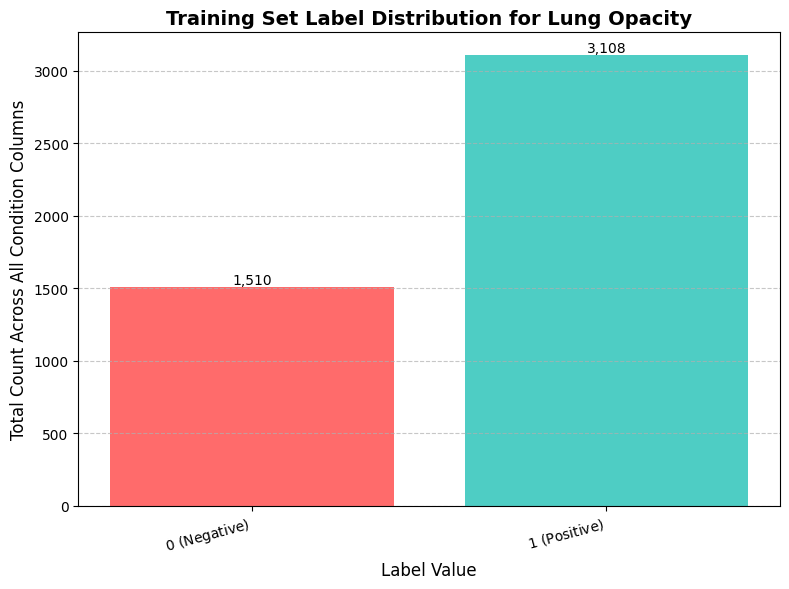

Plot saved as 'lung opacity_label_distribution.png'

--- Starting Data Load for Class: Lung Opacity ---
  Loaded train CSV: 4,618 entries. Verified images: 4,618.
  Loaded val CSV: 340 entries. Verified images: 340.
  Loaded test CSV: 2,123 entries. Verified images: 2,123.
Sucesfully Loaded Dataset


In [8]:
target_class="Lung Opacity"
# 1. Analyze the CSVs and retrieve the training dataframe
train_df_result = analyze_class_csv_stats(class_name=target_class)
# 2. Plot the label distribution for the retrieved training dataframe
visualize_training_label_distribution(class_name=target_class, train_df=train_df_result)
loaded_data = load_dataset(class_name="Lung Opacity")

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from PIL import Image

# Custom Dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, image_paths, transform=None):
        self.dataframe = dataframe
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Get the label from the dataframe
        df_idx = self.dataframe.index[self.dataframe['cxr_path'].str.contains(os.path.basename(img_path))][0]
        label = torch.tensor(self.dataframe.iloc[df_idx]['Lung Opacity'], dtype=torch.float32)

        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print ("Lung Opacity CXR dataset loaded" )

Lung Opacity CXR dataset loaded



--- Starting VGG Model Initialization (VGG16 on Lung Opacity dataset) ---
Using 2 GPUs! Training in parallel.

--- Starting VGG16(Lung Opacity) Model Training ---


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1/20 | Time: 56.89s
Training:    Loss: 0.0993, Acc: 0.5282, F1: 0.5272, AUC: 0.5372
Validation: Loss: 0.0847, Acc: 0.6000, F1: 0.6383, AUC: 0.6673
Saving new best model checkpoint...
Saved best model with validation AUC: 0.6673


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2/20 | Time: 50.86s
Training:    Loss: 0.0890, Acc: 0.5702, F1: 0.5646, AUC: 0.6036
Validation: Loss: 0.0809, Acc: 0.6441, F1: 0.6952, AUC: 0.7090
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7090


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 3/20 | Time: 49.16s
Training:    Loss: 0.0852, Acc: 0.5987, F1: 0.6183, AUC: 0.6370
Validation: Loss: 0.0739, Acc: 0.7265, F1: 0.8034, AUC: 0.7429
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7429


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 4/20 | Time: 47.45s
Training:    Loss: 0.0829, Acc: 0.6197, F1: 0.6229, AUC: 0.6643
Validation: Loss: 0.0739, Acc: 0.7265, F1: 0.7929, AUC: 0.7563
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7563

Epoch 5: Unfreezing last two convolutional blocks (Block 4 and 5).



Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 5/20 | Time: 52.80s
Training:    Loss: 0.0801, Acc: 0.6464, F1: 0.6556, AUC: 0.6928
Validation: Loss: 0.0764, Acc: 0.7029, F1: 0.7321, AUC: 0.8027
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8027


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6/20 | Time: 52.23s
Training:    Loss: 0.0775, Acc: 0.6728, F1: 0.6693, AUC: 0.7283
Validation: Loss: 0.0671, Acc: 0.7676, F1: 0.8159, AUC: 0.8219
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8219


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 7/20 | Time: 52.12s
Training:    Loss: 0.0755, Acc: 0.6793, F1: 0.6739, AUC: 0.7458
Validation: Loss: 0.0649, Acc: 0.7794, F1: 0.8292, AUC: 0.8326
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8326


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 8/20 | Time: 52.10s
Training:    Loss: 0.0750, Acc: 0.6847, F1: 0.6944, AUC: 0.7498
Validation: Loss: 0.0648, Acc: 0.7647, F1: 0.8086, AUC: 0.8318


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 9/20 | Time: 52.35s
Training:    Loss: 0.0730, Acc: 0.7072, F1: 0.7089, AUC: 0.7734
Validation: Loss: 0.0675, Acc: 0.7559, F1: 0.7888, AUC: 0.8446
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8446


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 10/20 | Time: 52.22s
Training:    Loss: 0.0735, Acc: 0.6992, F1: 0.6904, AUC: 0.7670
Validation: Loss: 0.0659, Acc: 0.7941, F1: 0.8341, AUC: 0.8520
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8520


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 11/20 | Time: 52.49s
Training:    Loss: 0.0710, Acc: 0.7081, F1: 0.7167, AUC: 0.7820
Validation: Loss: 0.0673, Acc: 0.7441, F1: 0.7775, AUC: 0.8517


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 12/20 | Time: 52.06s
Training:    Loss: 0.0703, Acc: 0.7159, F1: 0.7217, AUC: 0.7884
Validation: Loss: 0.0606, Acc: 0.7853, F1: 0.8298, AUC: 0.8523
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8523


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 13/20 | Time: 52.99s
Training:    Loss: 0.0722, Acc: 0.7120, F1: 0.7193, AUC: 0.7768
Validation: Loss: 0.0694, Acc: 0.7471, F1: 0.7760, AUC: 0.8531
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8531


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 14/20 | Time: 52.86s
Training:    Loss: 0.0698, Acc: 0.7213, F1: 0.7330, AUC: 0.7956
Validation: Loss: 0.0587, Acc: 0.8235, F1: 0.8712, AUC: 0.8542
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8542


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 15/20 | Time: 52.56s
Training:    Loss: 0.0703, Acc: 0.7176, F1: 0.7325, AUC: 0.7900
Validation: Loss: 0.0643, Acc: 0.7588, F1: 0.7980, AUC: 0.8588
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8588


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 16/20 | Time: 51.83s
Training:    Loss: 0.0703, Acc: 0.7165, F1: 0.7266, AUC: 0.7919
Validation: Loss: 0.0601, Acc: 0.8000, F1: 0.8426, AUC: 0.8606
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8606


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 17/20 | Time: 52.27s
Training:    Loss: 0.0685, Acc: 0.7306, F1: 0.7343, AUC: 0.8043
Validation: Loss: 0.0672, Acc: 0.7588, F1: 0.7919, AUC: 0.8543


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 18/20 | Time: 52.07s
Training:    Loss: 0.0680, Acc: 0.7367, F1: 0.7402, AUC: 0.8103
Validation: Loss: 0.0648, Acc: 0.7500, F1: 0.7901, AUC: 0.8565


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 19/20 | Time: 51.97s
Training:    Loss: 0.0684, Acc: 0.7274, F1: 0.7369, AUC: 0.8073
Validation: Loss: 0.0608, Acc: 0.7794, F1: 0.8244, AUC: 0.8584


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 20/20 | Time: 51.92s
Training:    Loss: 0.0661, Acc: 0.7404, F1: 0.7504, AUC: 0.8185
Validation: Loss: 0.0605, Acc: 0.7647, F1: 0.8077, AUC: 0.8596

--- Storing Training History and Plots ---


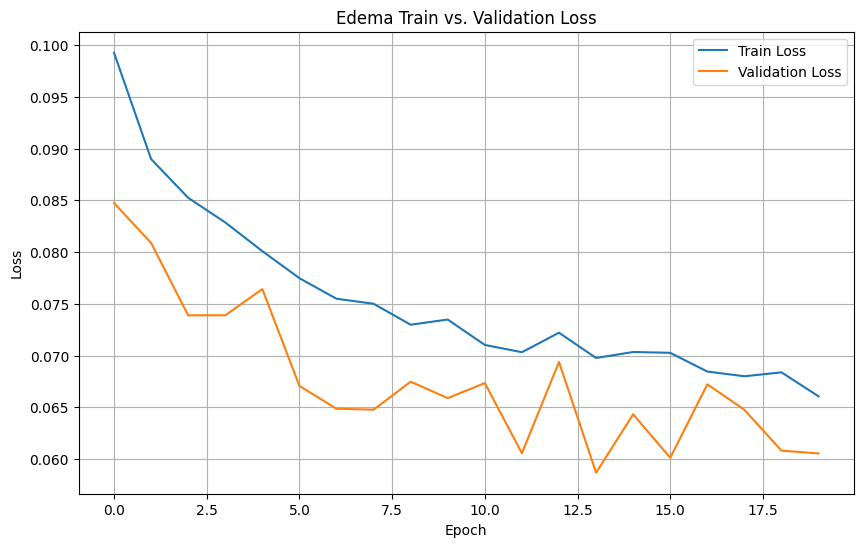


Model training history saved.

--- Starting Final Evaluation on Test Dataset ---


Testing:   0%|          | 0/34 [00:00<?, ?it/s]


Optimal Threshold found: 0.4713

Final Test Set Evaluation Scores
                        Score  95% CI Lower  95% CI Upper
Metric                                                   
AUC                  0.787940      0.768006      0.805677
Accuracy (Optimal)   0.747056      0.728686      0.764496
F1-Score (Optimal)   0.811645      0.796223      0.826564
Precision (Optimal)  0.757199      0.736124      0.779518
Recall (Optimal)     0.874528      0.856702      0.892564
Accuracy (Default)   0.716439      0.696656      0.734338
F1-Score (Default)   0.772830      0.754576      0.789905
Precision (Default)  0.771665      0.749251      0.794260
Recall (Default)     0.773998      0.750379      0.795920

Evaluation scores saved to 'Lung Opacity evaluation_scores_with_ci.csv'

--- Plotting Final Confusion Matrices and Curves ---

Lung Opacity Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

    Negative       0.62      0.62      0.62       80

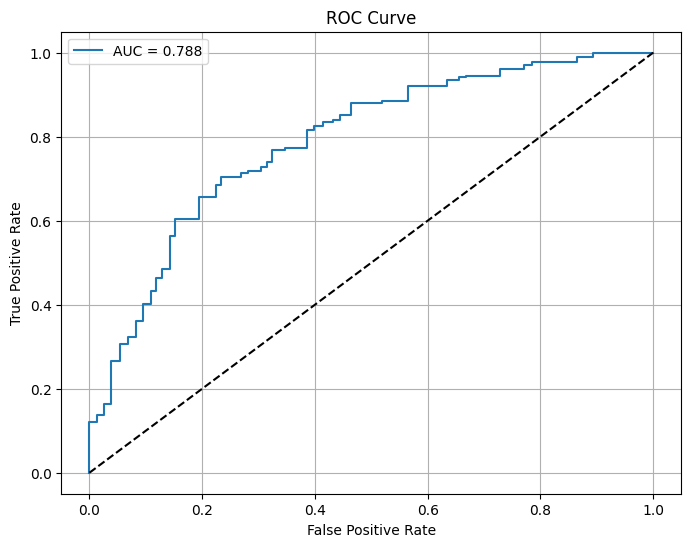

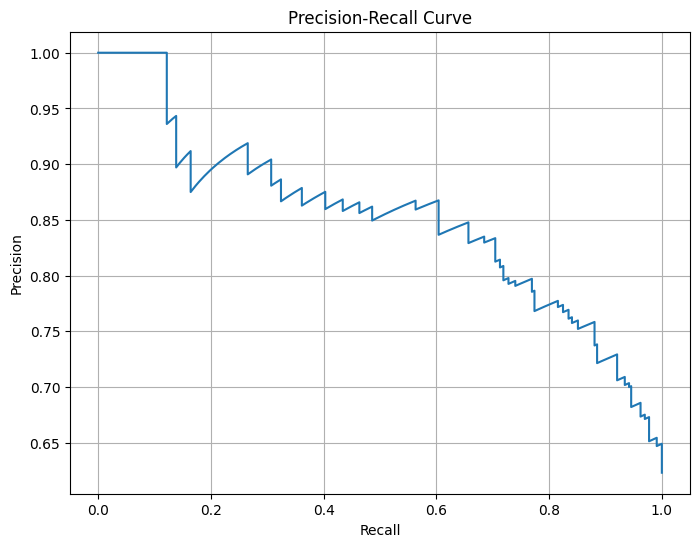

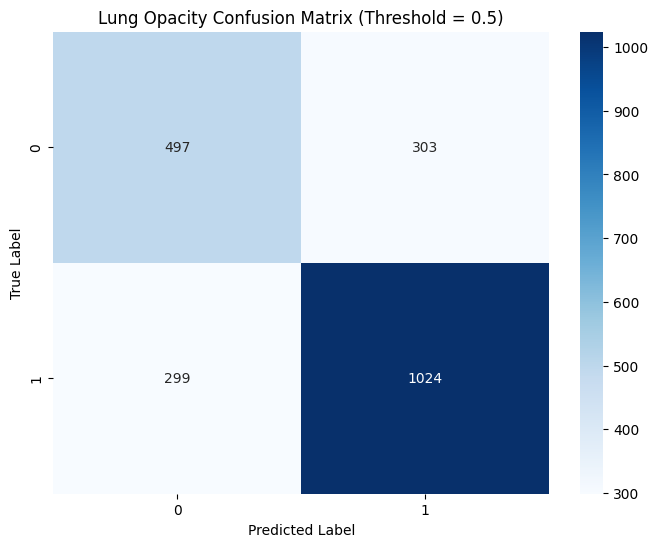

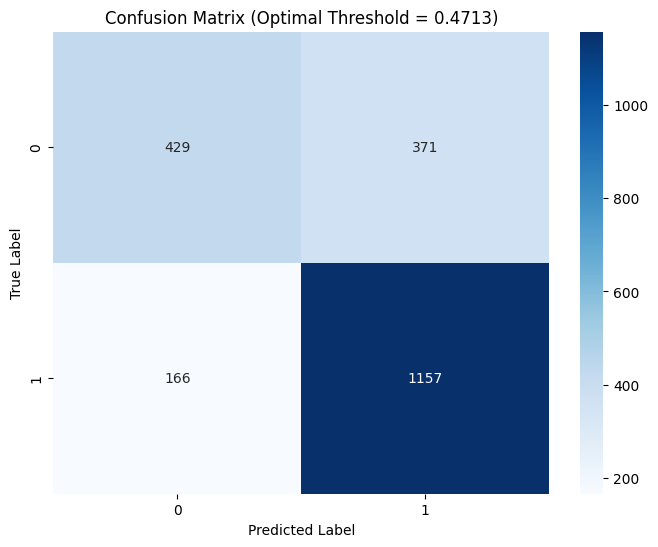

In [10]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision import models, transforms
from tqdm.auto import tqdm
import time
import pickle


class FocalLoss(nn.Module):
    """
    Focal Loss for binary classification.
    """
    def __init__(self, alpha=0.5, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# VGG16 FEATURE EXTRACTOR 
class VGG16FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16FeatureExtractor, self).__init__()
        
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)

        for param in self.vgg.features.parameters():
            param.requires_grad = False

        num_vgg_features = self.vgg.features[-3].out_channels  
        self.vgg.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.vgg.classifier = nn.Sequential(
            nn.Linear(num_vgg_features, 512), 
            nn.ReLU(True),
            nn.Dropout(0.5)
        )
        
        for m in self.vgg.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.vgg.features(x)
        x = self.vgg.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.vgg.classifier(x) 
        return x

# VGG16 FULL MODEL WRAPPER 

class VGG16FullModel(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(VGG16FullModel, self).__init__()
        self.extractor = VGG16FeatureExtractor(pretrained=pretrained)
        
        self.final_classifier = nn.Linear(512, num_classes)
        
        nn.init.xavier_normal_(self.final_classifier.weight)
        nn.init.constant_(self.final_classifier.bias, 0)
        
    def forward(self, x):
        x = self.extractor(x)
        x = self.final_classifier(x)
        return x


def create_vgg16_model(num_classes=1, pretrained=True):
    return VGG16FullModel(num_classes=num_classes, pretrained=pretrained)


# DATA TRANSFORMS, SAMPLER, AND DATALOADERS

cpu_initial_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor()          
])


gpu_train_transforms = torch.nn.Sequential(
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


gpu_eval_transforms = torch.nn.Sequential(
    transforms.CenterCrop(224), # For eval, we just crop the center
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


train_dataset = ChestXRayDataset(
    loaded_data['train']['df'],
    loaded_data['train']['image_paths'],
    transform=cpu_initial_transform 
)

val_dataset = ChestXRayDataset(
    loaded_data['val']['df'],
    loaded_data['val']['image_paths'],
    transform=cpu_initial_transform 
)

labels = loaded_data['train']['df']['Lung Opacity'].values
unique_labels = np.unique(labels)
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in unique_labels])
weight = 1. / class_sample_count
label_to_weight = dict(zip(unique_labels, weight))
samples_weight = np.array([label_to_weight[label] for label in labels])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

BATCH_SIZE = 64


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0, 
    pin_memory=True 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0, 
    pin_memory=True
)

# MODEL, OPTIMIZER, AND SCHEDULER INITIALIZATION

print("\n--- Starting VGG Model Initialization (VGG16 on Lung Opacity dataset) ---")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Use the updated model creation function
model = create_vgg16_model(num_classes=1)
model = model.to(device)

gpu_train_transforms = gpu_train_transforms.to(device)
gpu_eval_transforms = gpu_eval_transforms.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs! Training in parallel.")
    model = nn.DataParallel(model)

criterion = FocalLoss(alpha=0.5, gamma=2.0)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=0.01,
    amsgrad=True
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)


# TRAINING AND VALIDATION FUNCTIONS

def train_epoch(model, loader, criterion, optimizer, device, gpu_transforms):
    model.train()
    running_loss = 0.0
    predictions, true_labels = [], []
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        inputs = gpu_transforms(inputs)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions.extend(torch.sigmoid(outputs).cpu().detach().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions).squeeze()
    true_labels = np.array(true_labels)
    pred_labels = (predictions > 0.5).astype(int)
    return (running_loss / len(loader), 
            accuracy_score(true_labels, pred_labels), 
            f1_score(true_labels, pred_labels), 
            roc_auc_score(true_labels, predictions))

def validate(model, loader, criterion, device, gpu_transforms):
    model.eval()
    running_loss = 0.0
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            inputs = gpu_transforms(inputs)
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            running_loss += loss.item()
            predictions.extend(torch.sigmoid(outputs).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions).squeeze()
    true_labels = np.array(true_labels)
    pred_labels = (predictions > 0.5).astype(int)
    return (running_loss / len(loader), 
            accuracy_score(true_labels, pred_labels), 
            f1_score(true_labels, pred_labels), 
            roc_auc_score(true_labels, predictions))


# TRAINING LOOP 

print("\n--- Starting VGG16(Lung Opacity) Model Training ---")
num_epochs = 20
best_val_auc = 0.0
patience = 5
epochs_no_improve = 0
early_stop = False
UNFREEZE_EPOCH = 4
history = {k: [] for k in ['train_loss', 'train_acc', 'train_f1', 'train_auc', 'val_loss', 'val_acc', 'val_f1', 'val_auc', 'epoch_time']}

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    if early_stop:
        print(f"\nEarly stopping: Validation AUC did not improve for {patience} epochs.")
        break

    if epoch == UNFREEZE_EPOCH:
        print("\n" + "="*50 + f"\nEpoch {epoch+1}: Unfreezing last two convolutional blocks (Block 4 and 5).\n" + "="*50 + "\n")
        
        model_to_unfreeze = model.module if isinstance(model, nn.DataParallel) else model
        
        
        unfrozen_layers = model_to_unfreeze.extractor.vgg.features[17:]
        
        for param in unfrozen_layers.parameters():
            param.requires_grad = True
            
        params_group_1_features = unfrozen_layers.parameters()
        params_group_2_vgg_head = model_to_unfreeze.extractor.vgg.classifier.parameters()   
        params_group_3_final_head = model_to_unfreeze.final_classifier.parameters()
            
       
        optimizer = torch.optim.AdamW([
            {'params': params_group_1_features, 'lr': 1e-5}, 
            {'params': list(params_group_2_vgg_head) + list(params_group_3_final_head), 'lr': 1e-4} 
        ], weight_decay=0.01, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    start_time = time.time()
    train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device, gpu_train_transforms)
    val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device, gpu_eval_transforms)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)
    history['epoch_time'].append(time.time() - start_time)

    scheduler.step(val_auc)
    print(f'\nEpoch {epoch+1}/{num_epochs} | Time: {history["epoch_time"][-1]:.2f}s')
    print(f'Training:    Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}')
    print(f'Validation: Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        epochs_no_improve = 0
        print("Saving new best model checkpoint...")
        state_dict_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict_to_save, 'best_Lung_Opacity_vgg16_model.pth')
        print(f'Saved best model with validation AUC: {val_auc:.4f}')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

# PLOTTING AND HISTORY STORAGE (Pre-evaluation)

print("\n--- Storing Training History and Plots ---")
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Edema Train vs. Validation Loss'), plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend(), plt.grid(True)
plt.savefig('Edema train_val_loss_plot.png'), plt.show()

with open('Lung_Opacity_vgg16_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print("\nModel training history saved.")


# FINAL EVALUATION ON TEST SET

print("\n--- Starting Final Evaluation on Test Dataset ---")

# Load best model for evaluation
eval_model = create_vgg16_model()
eval_model.load_state_dict(torch.load('best_Lung_Opacity_vgg16_model.pth'))
eval_model.to(device)
eval_model.eval()

test_loader = DataLoader(
    ChestXRayDataset(loaded_data['test']['df'], loaded_data['test']['image_paths'], transform=cpu_initial_transform),
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

y_true, y_prob = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device, non_blocking=True)
        
        inputs = gpu_eval_transforms(inputs)
        
        y_true.extend(labels.numpy())
        outputs = eval_model(inputs)
        y_prob.extend(torch.sigmoid(outputs).cpu().numpy())
y_true, y_prob = np.array(y_true), np.array(y_prob).squeeze()

def bootstrap_metric(y_true, y_pred, metric_func, n_bootstraps=1000):
    """Calculates 95% CI for a given metric using bootstrapping."""
    bootstrapped_scores = []
    rng = np.random.RandomState(42)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    lower_bound = np.percentile(sorted_scores, 2.5)
    upper_bound = np.percentile(sorted_scores, 97.5)
    
    return lower_bound, upper_bound

precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal Threshold found: {best_threshold:.4f}")


y_pred_default = (y_prob > 0.5).astype(int)
y_pred_optimal = (y_prob > best_threshold).astype(int)

# Store results
evaluation_results = []

# 1. AUC Score (threshold-independent)
auc_score = roc_auc_score(y_true, y_prob)
auc_ci_lower, auc_ci_upper = bootstrap_metric(y_true, y_prob, roc_auc_score)
evaluation_results.append({'Metric': 'AUC', 'Score': auc_score, '95% CI Lower': auc_ci_lower, '95% CI Upper': auc_ci_upper})

# 2. Metrics for Optimal Threshold
metrics_to_calc = {
    "Accuracy": accuracy_score,
    "F1-Score": f1_score,
    "Precision": precision_score,
    "Recall": recall_score
}

for name, func in metrics_to_calc.items():
    score = func(y_true, y_pred_optimal)
    ci_lower, ci_upper = bootstrap_metric(y_true, y_pred_optimal, func)
    evaluation_results.append({'Metric': f'{name} (Optimal)', 'Score': score, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

# 3. Metrics for Default Threshold (0.5)
for name, func in metrics_to_calc.items():
    score = func(y_true, y_pred_default)
    ci_lower, ci_upper = bootstrap_metric(y_true, y_pred_default, func)
    evaluation_results.append({'Metric': f'{name} (Default)', 'Score': score, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

# Create and save DataFrame
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.set_index('Metric')
print("\n" + "="*50 + "\nFinal Test Set Evaluation Scores\n" + "="*50)
print(results_df)

# Save to CSV
results_df.to_csv('Edema_evaluation_scores_with_ci.csv')
print("\nEvaluation scores saved to 'Lung Opacity evaluation_scores_with_ci.csv'")

# --- PLOTTING FINAL RESULTS ---
print("\n--- Plotting Final Confusion Matrices and Curves ---")

# Classification reports
print("\nLung Opacity Classification Report (Default Threshold 0.5):")
print(classification_report(y_true, y_pred_default, target_names=['Negative', 'Positive']))
print("\nCLung Opacity Classification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal, target_names=['Negative', 'Positive']))

# Plotting curves
def plot_curve(x, y, x_label, y_label, title, file_name, auc_score_val=None):
    plt.figure(figsize=(8, 6))
    label = f'AUC = {auc_score_val:.3f}' if auc_score_val is not None else None
    plt.plot(x, y, label=label)
    if auc_score_val is not None:
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend()
    plt.xlabel(x_label), plt.ylabel(y_label), plt.title(title), plt.grid(True)
    plt.savefig(file_name), plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
plot_curve(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC Curve', 'Cardiomegaly roc_curve.png', auc_score_val=auc_score)
plot_curve(recall, precision, 'Recall', 'Precision', 'Precision-Recall Curve', 'Cardiomegaly precision_recall_curve.png')

# Plotting confusion matrices
def plot_confusion_matrix(cm, title, file_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title), plt.ylabel('True Label'), plt.xlabel('Predicted Label')
    plt.savefig(file_name), plt.show()

plot_confusion_matrix(confusion_matrix(y_true, y_pred_default), 'Lung Opacity Confusion Matrix (Threshold = 0.5)', 'Lung Opacity confusion_matrix_default.png')
plot_confusion_matrix(confusion_matrix(y_true, y_pred_optimal), f'Confusion Matrix (Optimal Threshold = {best_threshold:.4f})', 'Lung Opacityconfusion_matrix_optimal.png')


## Pleural Effusion

STATISTICAL ANALYSIS FOR CLASS: PLEURAL EFFUSION

--- TRAIN SET (Pleural Effusion_train.csv) ---
Total entries (Row Count): 6,441

Condition label distribution (per column):
  • Pleural Effusion:
    - Positive (1) :   3,618 ( 56.2%)
    - Negative (0) :   2,823
    - Total Labeled:   6,441

--- VAL SET (Pleural Effusion_val.csv) ---
Total entries (Row Count): 490

Condition label distribution (per column):
  • Pleural Effusion:
    - Positive (1) :     253 ( 51.6%)
    - Negative (0) :     237
    - Total Labeled:     490

--- TEST SET (Pleural Effusion_test.csv) ---
Total entries (Row Count): 3,148

Condition label distribution (per column):
  • Pleural Effusion:
    - Positive (1) :   1,681 ( 53.4%)
    - Negative (0) :   1,467
    - Total Labeled:   3,148

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PLOTTING TRAINING SET LABEL DISTRIBUTION FOR: PLEURAL EFFUSION
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Training Set total labe

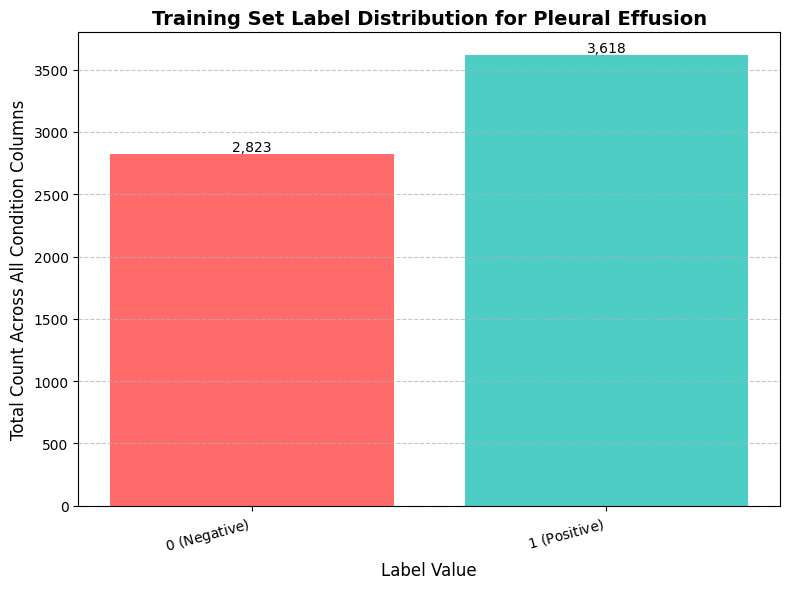

Plot saved as 'pleural effusion_label_distribution.png'

--- Starting Data Load for Class: Pleural Effusion ---
  Loaded train CSV: 6,441 entries. Verified images: 6,441.
  Loaded val CSV: 490 entries. Verified images: 490.
  Loaded test CSV: 3,148 entries. Verified images: 3,148.
Sucesfully Loaded Dataset


In [11]:
target_class="Pleural Effusion"
# 1. Analyze the CSVs and retrieve the training dataframe
train_df_result = analyze_class_csv_stats(class_name=target_class)
# 2. Plot the label distribution for the retrieved training dataframe
visualize_training_label_distribution(class_name=target_class, train_df=train_df_result)
loaded_data = load_dataset(class_name="Pleural Effusion")

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from PIL import Image

# Custom Dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, image_paths, transform=None):
        self.dataframe = dataframe
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Get the label from the dataframe
        df_idx = self.dataframe.index[self.dataframe['cxr_path'].str.contains(os.path.basename(img_path))][0]
        label = torch.tensor(self.dataframe.iloc[df_idx]['Pleural Effusion'], dtype=torch.float32)

        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print ("Pleural Effusion CXR dataset loaded" )

Pleural Effusion CXR dataset loaded



--- Starting VGG Model Initialization (VGG16 on Pleural Effusion dataset) ---
Using 2 GPUs! Training in parallel.

--- Starting VGG16(Pleural Effusion) Model Training ---


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 1/20 | Time: 73.08s
Training:    Loss: 0.0956, Acc: 0.5633, F1: 0.5538, AUC: 0.5737
Validation: Loss: 0.0772, Acc: 0.6490, F1: 0.6195, AUC: 0.7394
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7394


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 2/20 | Time: 70.38s
Training:    Loss: 0.0846, Acc: 0.6114, F1: 0.6088, AUC: 0.6580
Validation: Loss: 0.0721, Acc: 0.7245, F1: 0.7576, AUC: 0.7904
Saving new best model checkpoint...
Saved best model with validation AUC: 0.7904


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 3/20 | Time: 68.77s
Training:    Loss: 0.0800, Acc: 0.6414, F1: 0.6500, AUC: 0.7017
Validation: Loss: 0.0701, Acc: 0.7306, F1: 0.7537, AUC: 0.8010
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8010


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 4/20 | Time: 68.82s
Training:    Loss: 0.0785, Acc: 0.6654, F1: 0.6710, AUC: 0.7181
Validation: Loss: 0.0705, Acc: 0.7143, F1: 0.7595, AUC: 0.8094
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8094

Epoch 5: Unfreezing last two convolutional blocks (Block 4 and 5).



Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 5/20 | Time: 76.59s
Training:    Loss: 0.0750, Acc: 0.6892, F1: 0.6955, AUC: 0.7521
Validation: Loss: 0.0639, Acc: 0.7531, F1: 0.7613, AUC: 0.8377
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8377


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 6/20 | Time: 77.48s
Training:    Loss: 0.0706, Acc: 0.7255, F1: 0.7275, AUC: 0.7909
Validation: Loss: 0.0618, Acc: 0.7796, F1: 0.7805, AUC: 0.8515
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8515


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 7/20 | Time: 77.75s
Training:    Loss: 0.0690, Acc: 0.7358, F1: 0.7448, AUC: 0.8050
Validation: Loss: 0.0606, Acc: 0.7755, F1: 0.7764, AUC: 0.8547
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8547


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 8/20 | Time: 77.34s
Training:    Loss: 0.0664, Acc: 0.7480, F1: 0.7497, AUC: 0.8217
Validation: Loss: 0.0600, Acc: 0.7796, F1: 0.7939, AUC: 0.8618
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8618


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 9/20 | Time: 76.38s
Training:    Loss: 0.0645, Acc: 0.7670, F1: 0.7727, AUC: 0.8356
Validation: Loss: 0.0591, Acc: 0.7939, F1: 0.8008, AUC: 0.8635
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8635


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 10/20 | Time: 76.44s
Training:    Loss: 0.0650, Acc: 0.7569, F1: 0.7657, AUC: 0.8314
Validation: Loss: 0.0587, Acc: 0.7816, F1: 0.7970, AUC: 0.8669
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8669


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 11/20 | Time: 77.06s
Training:    Loss: 0.0634, Acc: 0.7660, F1: 0.7741, AUC: 0.8409
Validation: Loss: 0.0579, Acc: 0.7878, F1: 0.8000, AUC: 0.8711
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8711


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 12/20 | Time: 77.34s
Training:    Loss: 0.0626, Acc: 0.7696, F1: 0.7718, AUC: 0.8463
Validation: Loss: 0.0571, Acc: 0.7980, F1: 0.8040, AUC: 0.8744
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8744


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 13/20 | Time: 76.30s
Training:    Loss: 0.0620, Acc: 0.7710, F1: 0.7796, AUC: 0.8491
Validation: Loss: 0.0575, Acc: 0.7939, F1: 0.7943, AUC: 0.8739


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 14/20 | Time: 76.81s
Training:    Loss: 0.0613, Acc: 0.7831, F1: 0.7818, AUC: 0.8547
Validation: Loss: 0.0567, Acc: 0.7980, F1: 0.7984, AUC: 0.8760
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8760


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 15/20 | Time: 77.18s
Training:    Loss: 0.0617, Acc: 0.7749, F1: 0.7746, AUC: 0.8532
Validation: Loss: 0.0620, Acc: 0.7592, F1: 0.7366, AUC: 0.8735


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 16/20 | Time: 76.71s
Training:    Loss: 0.0615, Acc: 0.7764, F1: 0.7749, AUC: 0.8536
Validation: Loss: 0.0576, Acc: 0.7918, F1: 0.7910, AUC: 0.8750


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 17/20 | Time: 76.54s
Training:    Loss: 0.0598, Acc: 0.7826, F1: 0.7880, AUC: 0.8610
Validation: Loss: 0.0588, Acc: 0.7898, F1: 0.8103, AUC: 0.8738


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 18/20 | Time: 76.76s
Training:    Loss: 0.0585, Acc: 0.7913, F1: 0.7969, AUC: 0.8706
Validation: Loss: 0.0566, Acc: 0.8020, F1: 0.8102, AUC: 0.8754


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 19/20 | Time: 76.72s
Training:    Loss: 0.0598, Acc: 0.7856, F1: 0.7868, AUC: 0.8626
Validation: Loss: 0.0575, Acc: 0.7980, F1: 0.7942, AUC: 0.8764
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8764


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 20/20 | Time: 76.50s
Training:    Loss: 0.0578, Acc: 0.7915, F1: 0.7919, AUC: 0.8724
Validation: Loss: 0.0565, Acc: 0.7959, F1: 0.7984, AUC: 0.8786
Saving new best model checkpoint...
Saved best model with validation AUC: 0.8786

--- Storing Training History and Plots ---


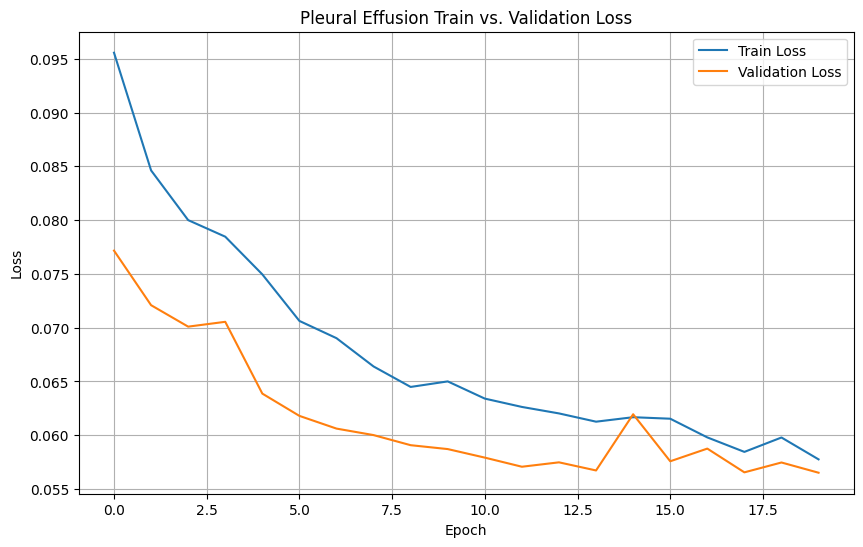


Model training history saved.

--- Starting Final Evaluation on Test Dataset ---


Testing:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal Threshold found: 0.4022

Final Test Set Evaluation Scores
                        Score  95% CI Lower  95% CI Upper
Metric                                                   
AUC                  0.856420      0.843130      0.869757
Accuracy (Optimal)   0.772554      0.757624      0.786531
F1-Score (Optimal)   0.802646      0.788361      0.816095
Precision (Optimal)  0.747817      0.728351      0.765149
Recall (Optimal)     0.866151      0.849880      0.882596
Accuracy (Default)   0.793520      0.778907      0.807814
F1-Score (Default)   0.795211      0.779709      0.810971
Precision (Default)  0.845278      0.827829      0.863044
Recall (Default)     0.750744      0.729571      0.770710

Evaluation scores saved to 'Pleural Effusion_evaluation_scores_with_ci.csv'

--- Plotting Final Confusion Matrices and Curves ---

Pleural Effusion Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

    Negative       0.75      0.84      0.79 

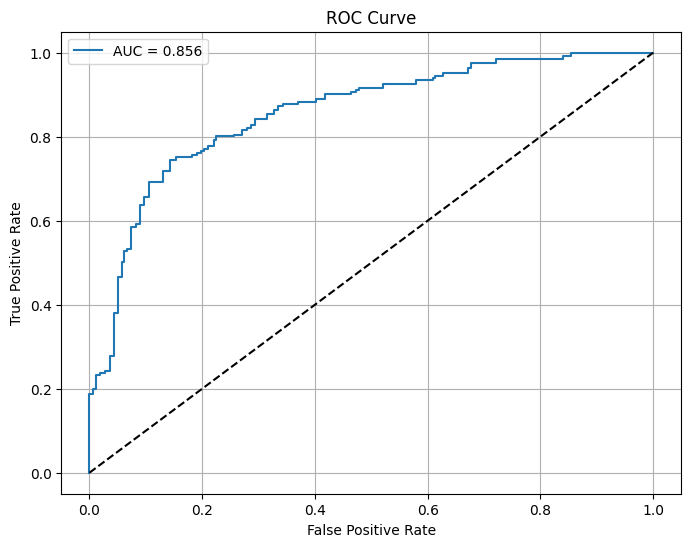

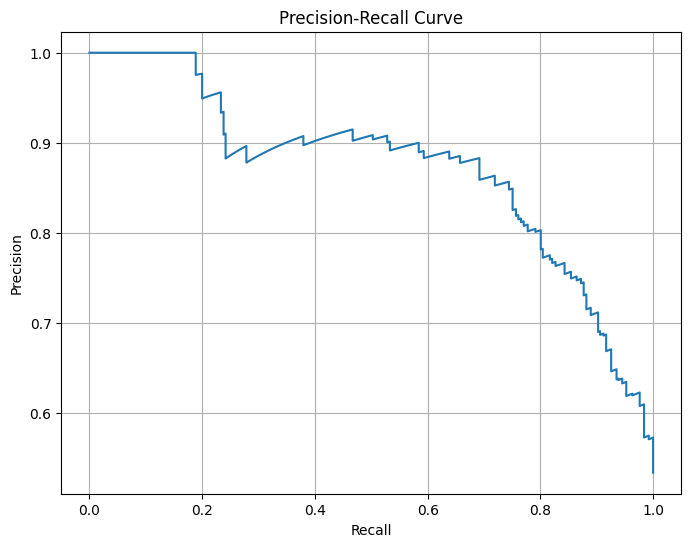

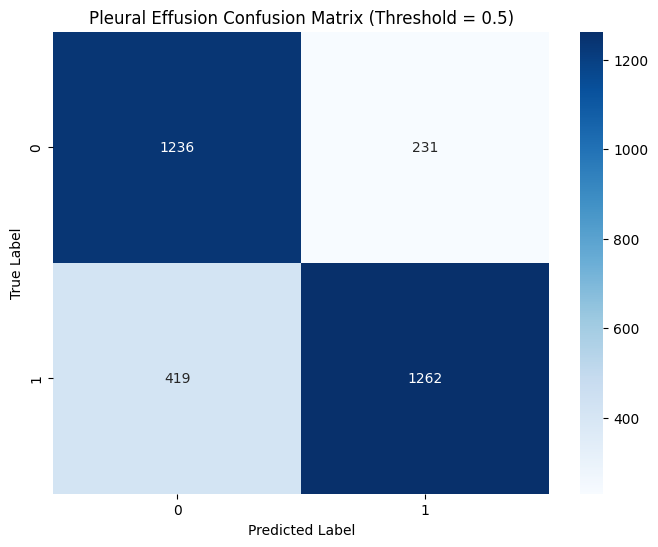

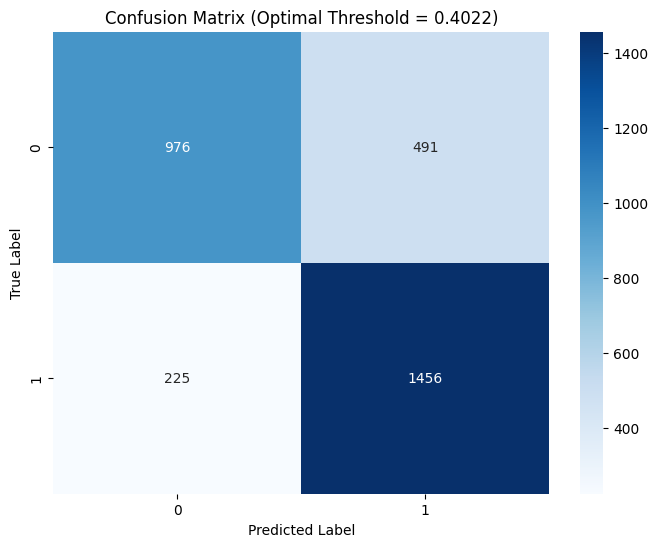

In [15]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision import models, transforms
from tqdm.auto import tqdm
import time
import pickle


class FocalLoss(nn.Module):
    """
    Focal Loss for binary classification.
    """
    def __init__(self, alpha=0.5, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# VGG16 FEATURE EXTRACTOR 
class VGG16FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16FeatureExtractor, self).__init__()
        
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)

        for param in self.vgg.features.parameters():
            param.requires_grad = False

        num_vgg_features = self.vgg.features[-3].out_channels  
        self.vgg.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.vgg.classifier = nn.Sequential(
            nn.Linear(num_vgg_features, 512), 
            nn.ReLU(True),
            nn.Dropout(0.5)
        )
        
        for m in self.vgg.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.vgg.features(x)
        x = self.vgg.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.vgg.classifier(x) 
        return x

# VGG16 FULL MODEL WRAPPER 

class VGG16FullModel(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(VGG16FullModel, self).__init__()
        self.extractor = VGG16FeatureExtractor(pretrained=pretrained)
        
        self.final_classifier = nn.Linear(512, num_classes)
        
        nn.init.xavier_normal_(self.final_classifier.weight)
        nn.init.constant_(self.final_classifier.bias, 0)
        
    def forward(self, x):
        x = self.extractor(x)
        x = self.final_classifier(x)
        return x


def create_vgg16_model(num_classes=1, pretrained=True):
    # Instantiate the new full model wrapper
    return VGG16FullModel(num_classes=num_classes, pretrained=pretrained)

# DATA TRANSFORMS, SAMPLER, AND DATALOADERS

cpu_initial_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor()          
])


gpu_train_transforms = torch.nn.Sequential(
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


gpu_eval_transforms = torch.nn.Sequential(
    transforms.CenterCrop(224), # For eval, we just crop the center
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


train_dataset = ChestXRayDataset(
    loaded_data['train']['df'],
    loaded_data['train']['image_paths'],
    transform=cpu_initial_transform 
)

val_dataset = ChestXRayDataset(
    loaded_data['val']['df'],
    loaded_data['val']['image_paths'],
    transform=cpu_initial_transform 
)

labels = loaded_data['train']['df']['Lung Opacity'].values
unique_labels = np.unique(labels)
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in unique_labels])
weight = 1. / class_sample_count
label_to_weight = dict(zip(unique_labels, weight))
samples_weight = np.array([label_to_weight[label] for label in labels])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

BATCH_SIZE = 64


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0, 
    pin_memory=True 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0, 
    pin_memory=True
)


# MODEL, OPTIMIZER, AND SCHEDULER INITIALIZATION

print("\n--- Starting VGG Model Initialization (VGG16 on Pleural Effusion dataset) ---")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = create_vgg16_model(num_classes=1)
model = model.to(device)

gpu_train_transforms = gpu_train_transforms.to(device)
gpu_eval_transforms = gpu_eval_transforms.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs! Training in parallel.")
    model = nn.DataParallel(model)

\criterion = FocalLoss(alpha=0.5, gamma=2.0)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=0.01,
    amsgrad=True
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

# TRAINING AND VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device, gpu_transforms):
    model.train()
    running_loss = 0.0
    predictions, true_labels = [], []
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        inputs = gpu_transforms(inputs)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions.extend(torch.sigmoid(outputs).cpu().detach().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions).squeeze()
    true_labels = np.array(true_labels)
    pred_labels = (predictions > 0.5).astype(int)
    return (running_loss / len(loader), 
            accuracy_score(true_labels, pred_labels), 
            f1_score(true_labels, pred_labels), 
            roc_auc_score(true_labels, predictions))

def validate(model, loader, criterion, device, gpu_transforms):
    model.eval()
    running_loss = 0.0
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            inputs = gpu_transforms(inputs)
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            running_loss += loss.item()
            predictions.extend(torch.sigmoid(outputs).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions).squeeze()
    true_labels = np.array(true_labels)
    pred_labels = (predictions > 0.5).astype(int)
    return (running_loss / len(loader), 
            accuracy_score(true_labels, pred_labels), 
            f1_score(true_labels, pred_labels), 
            roc_auc_score(true_labels, predictions))

# TRAINING LOOP 

print("\n--- Starting VGG16(Pleural Effusion) Model Training ---")
num_epochs = 20
best_val_auc = 0.0
patience = 5
epochs_no_improve = 0
early_stop = False
UNFREEZE_EPOCH = 4
history = {k: [] for k in ['train_loss', 'train_acc', 'train_f1', 'train_auc', 'val_loss', 'val_acc', 'val_f1', 'val_auc', 'epoch_time']}

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    if early_stop:
        print(f"\nEarly stopping: Validation AUC did not improve for {patience} epochs.")
        break

    if epoch == UNFREEZE_EPOCH:
        print("\n" + "="*50 + f"\nEpoch {epoch+1}: Unfreezing last two convolutional blocks (Block 4 and 5).\n" + "="*50 + "\n")
        
        model_to_unfreeze = model.module if isinstance(model, nn.DataParallel) else model
        
       
        unfrozen_layers = model_to_unfreeze.extractor.vgg.features[17:]
        
        for param in unfrozen_layers.parameters():
            param.requires_grad = True
            
        params_group_1_features = unfrozen_layers.parameters()
        params_group_2_vgg_head = model_to_unfreeze.extractor.vgg.classifier.parameters()   
        params_group_3_final_head = model_to_unfreeze.final_classifier.parameters()
            
        optimizer = torch.optim.AdamW([
            {'params': params_group_1_features, 'lr': 1e-5}, 
            {'params': list(params_group_2_vgg_head) + list(params_group_3_final_head), 'lr': 1e-4} 
        ], weight_decay=0.01, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    start_time = time.time()
    train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device, gpu_train_transforms)
    val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device, gpu_eval_transforms)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)
    history['epoch_time'].append(time.time() - start_time)

    scheduler.step(val_auc)
    print(f'\nEpoch {epoch+1}/{num_epochs} | Time: {history["epoch_time"][-1]:.2f}s')
    print(f'Training:    Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}')
    print(f'Validation: Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        epochs_no_improve = 0
        print("Saving new best model checkpoint...")
        state_dict_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict_to_save, 'best_Pleural_Effusion_vgg16_model.pth')
        print(f'Saved best model with validation AUC: {val_auc:.4f}')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

# PLOTTING AND HISTORY STORAGE (Pre-evaluation)

print("\n--- Storing Training History and Plots ---")
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Pleural Effusion Train vs. Validation Loss'), plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend(), plt.grid(True)
plt.savefig('Pleural Effusion_train_val_loss_plot.png'), plt.show()

with open('Pleural_Effusion_vgg16_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print("\nModel training history saved.")

# FINAL EVALUATION ON TEST SET

print("\n--- Starting Final Evaluation on Test Dataset ---")

eval_model = create_vgg16_model()
eval_model.load_state_dict(torch.load('best_Pleural_Effusion_vgg16_model.pth'))
eval_model.to(device)
eval_model.eval()

test_loader = DataLoader(
    ChestXRayDataset(loaded_data['test']['df'], loaded_data['test']['image_paths'], transform=cpu_initial_transform),
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

y_true, y_prob = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device, non_blocking=True)
        
        inputs = gpu_eval_transforms(inputs)
        
        y_true.extend(labels.numpy())
        outputs = eval_model(inputs)
        y_prob.extend(torch.sigmoid(outputs).cpu().numpy())
y_true, y_prob = np.array(y_true), np.array(y_prob).squeeze()

def bootstrap_metric(y_true, y_pred, metric_func, n_bootstraps=1000):
    """Calculates 95% CI for a given metric using bootstrapping."""
    bootstrapped_scores = []
    rng = np.random.RandomState(42)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    lower_bound = np.percentile(sorted_scores, 2.5)
    upper_bound = np.percentile(sorted_scores, 97.5)
    
    return lower_bound, upper_bound


precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal Threshold found: {best_threshold:.4f}")



y_pred_default = (y_prob > 0.5).astype(int)
y_pred_optimal = (y_prob > best_threshold).astype(int)

# Store results
evaluation_results = []

# 1. AUC Score (threshold-independent)
auc_score = roc_auc_score(y_true, y_prob)
auc_ci_lower, auc_ci_upper = bootstrap_metric(y_true, y_prob, roc_auc_score)
evaluation_results.append({'Metric': 'AUC', 'Score': auc_score, '95% CI Lower': auc_ci_lower, '95% CI Upper': auc_ci_upper})

# 2. Metrics for Optimal Threshold
metrics_to_calc = {
    "Accuracy": accuracy_score,
    "F1-Score": f1_score,
    "Precision": precision_score,
    "Recall": recall_score
}

for name, func in metrics_to_calc.items():
    score = func(y_true, y_pred_optimal)
    ci_lower, ci_upper = bootstrap_metric(y_true, y_pred_optimal, func)
    evaluation_results.append({'Metric': f'{name} (Optimal)', 'Score': score, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

# 3. Metrics for Default Threshold (0.5)
for name, func in metrics_to_calc.items():
    score = func(y_true, y_pred_default)
    ci_lower, ci_upper = bootstrap_metric(y_true, y_pred_default, func)
    evaluation_results.append({'Metric': f'{name} (Default)', 'Score': score, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

# Create and save DataFrame
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.set_index('Metric')
print("\n" + "="*50 + "\nFinal Test Set Evaluation Scores\n" + "="*50)
print(results_df)

# Save to CSV
results_df.to_csv('Pleural Effusion_evaluation_scores_with_ci.csv')
# --- FIX: Correct print statement typo ---
print("\nEvaluation scores saved to 'Pleural Effusion_evaluation_scores_with_ci.csv'")

# --- PLOTTING FINAL RESULTS ---
print("\n--- Plotting Final Confusion Matrices and Curves ---")

# Classification reports
print("\nPleural Effusion Classification Report (Default Threshold 0.5):")
print(classification_report(y_true, y_pred_default, target_names=['Negative', 'Positive']))
print("\nPleural Effusion Classification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal, target_names=['Negative', 'Positive']))

# Plotting curves
def plot_curve(x, y, x_label, y_label, title, file_name, auc_score_val=None):
    plt.figure(figsize=(8, 6))
    label = f'AUC = {auc_score_val:.3f}' if auc_score_val is not None else None
    plt.plot(x, y, label=label)
    if auc_score_val is not None:
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend()
    plt.xlabel(x_label), plt.ylabel(y_label), plt.title(title), plt.grid(True)
    plt.savefig(file_name), plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
plot_curve(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC Curve', 'Pleural Effusion roc_curve.png', auc_score_val=auc_score)
plot_curve(recall, precision, 'Recall', 'Precision', 'Precision-Recall Curve', 'Pleural Effusion precision_recall_curve.png')

# Plotting confusion matrices
def plot_confusion_matrix(cm, title, file_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title), plt.ylabel('True Label'), plt.xlabel('Predicted Label')
    plt.savefig(file_name), plt.show()

plot_confusion_matrix(confusion_matrix(y_true, y_pred_default), 'Pleural Effusion Confusion Matrix (Threshold = 0.5)', 'Pleural Effusion confusion_matrix_default.png')
plot_confusion_matrix(confusion_matrix(y_true, y_pred_optimal), f'Confusion Matrix (Optimal Threshold = {best_threshold:.4f})', 'Pleural Effusion confusion_matrix_optimal.png')
